# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pickle
import itertools
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

/root/miniconda3/envs/HunyuanDiT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
5e4/60/24

34.72222222222222

# b. MNIST Data Loader

In [3]:
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
		transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. Unconditional GAN**


# a. Training Function for Discriminator

In [4]:
criterion = nn.BCELoss()

def train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels):
    discriminator.zero_grad()
    if with_condition:
      outputs = discriminator(images, cls_labels)
    else:
      outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels.view(-1, 1))
    real_score = outputs

    if with_condition:
      outputs = discriminator(fake_images, cls_labels)
    else:
      outputs = discriminator(fake_images)

    fake_loss = criterion(outputs, fake_labels.view(-1, 1))
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score, fake_loss

# b. Training Function for Generator

In [5]:
def train_generator(generator, g_optimizer, discriminator_outputs, real_labels, with_condition):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels.view(-1, 1))
    g_loss_fake = criterion(discriminator_outputs, 1 - real_labels.view(-1, 1))
    g_loss.backward()
    g_optimizer.step()
    return g_loss, g_loss_fake

# c. Monitors for Images and Losses


In [6]:
def monitor_images(generator, test_noise, with_condition):
    num_test_samples = test_noise.shape[0]
    size_figure_grid = int(math.sqrt(num_test_samples))
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(4, 4))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)

    if with_condition:
      cls_labels = torch.randint(0, 10, (num_test_samples,)).to(device)
      test_images = generator(test_noise, label = cls_labels)
    else:
      test_images = generator(test_noise)

    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
        if with_condition:
            ax[i, j].set_title(f'Class: {cls_labels[k].item()}', fontsize=10)
    plt.show()


def monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake):
    def moving_average(x, win=100):
        return np.convolve(x, np.ones(win), 'same') / np.convolve(np.ones_like(x), np.ones(win), 'same')

    plt.figure(figsize=(8, 3))
    iters = np.arange(len(d_losses))
    epochs = iters * batch_size / 60000
    plt.plot(epochs, moving_average(d_losses), label='d_loss')
    plt.plot(epochs, moving_average(g_losses), label='g_loss')
    plt.plot(epochs, moving_average(d_losses_fake), label='d_loss_fake')
    plt.plot(epochs, moving_average(g_losses_fake), label='g_loss_fake')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


# c. Model for Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, channels=[512, 256, 128], with_condition=False):
        super().__init__()
        self.with_condition = with_condition
        self.model = None

        ##################
        ### Problem 1: Implement Discriminator
        ##################
        self.model = [
            nn.Linear(784, channels[0]),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
        ]
        for i in range(len(channels) - 1):
            self.model += [
                nn.Linear(channels[i], channels[i + 1]),
                nn.LeakyReLU(),
                nn.Dropout(0.2),
            ]
        self.model += [nn.Linear(channels[-1], 1), nn.Sigmoid()]
        self.model = nn.Sequential(*self.model)

    def forward(self, x, label=None):
        x = x.view(x.size(0), 784)
        if self.with_condition:
            assert label is not None
            ##################
            ### Problem 3: Implement Conditional GAN
            ##################
        out = self.model(x)
        out = out.view(out.size(0), -1)
        return out


with torch.no_grad():
    discriminator = Discriminator(with_condition=False).to(device)
    for iter, (images, labels) in enumerate(test_loader):
        images = images.to(device)  # (128, 1, 28, 8)
        labels = labels.to(device)  # (128,)
        print(discriminator(images, labels).shape)
        break

torch.Size([128, 1])


# e. Model for Generator


In [8]:
class Generator(nn.Module):
    def __init__(self, dim_z=100, channels=[128, 256, 512], with_condition=False):
        super().__init__()
        self.dim_z = dim_z
        self.with_condition = with_condition

        self.model = None
        ##################
        ### Problem 1: Implement Generator
        ##################
        self.model = [nn.Linear(dim_z, channels[0]), nn.LeakyReLU()]
        for i in range(len(channels) - 1):
            self.model += [nn.Linear(channels[i], channels[i + 1]), nn.LeakyReLU()]
        self.model += [nn.Linear(channels[-1], 784), nn.Tanh()]
        self.model = nn.Sequential(*self.model)

    def forward(self, x, label=None):
        x = x.view(x.size(0), self.dim_z)

        if self.with_condition:
            assert label is not None
            ##################
            ### Problem 3: Implement Conditional GAN
            ##################

        out = self.model(x)
        return out


with torch.no_grad():
    generator = Generator(with_condition=False).to(device)
    noise = Variable(torch.randn(batch_size, generator.dim_z)).to(device)
    print(generator(noise).shape)

torch.Size([128, 784])


# d. Training

In [9]:
num_batches = len(train_loader)

def train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise,
                    num_epochs, d_freq, with_condition):
  d_losses = []
  g_losses = []
  d_losses_fake = []
  g_losses_fake = []
  dim_z = generator.dim_z
  for epoch in range(num_epochs):
      for n, (images, cls_labels) in enumerate(train_loader):
          images = Variable(images.to(device)) # (batch_size, 1, 28, 28)
          real_labels = Variable(torch.ones(images.size(0)).to(device)) # (batch_size, )
          cls_labels = cls_labels.to(device) # (batch_size, )

          # Sample from generator
          noise = Variable(torch.randn(images.size(0), dim_z).to(device)) # (batch_size, dim_z)
          fake_images = generator(noise, label=cls_labels if with_condition else None) # (batch_size, 784)
          fake_labels = Variable(torch.zeros(images.size(0)).to(device)) # (batch_size, )

          # Train the discriminator
          d_loss, real_score, fake_score, d_loss_fake = train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels=cls_labels)

          if n % d_freq == 0:
            noise = Variable(torch.randn(images.size(0), dim_z).to(device)) # (batch_size, dim_z)

            # Sample again from the generator and get output from discriminator
            fake_images = generator(noise, label=cls_labels if with_condition else None)
            outputs = discriminator(fake_images, label=cls_labels if with_condition else None)

            # Train the generator
            g_loss, g_loss_fake = train_generator(generator, g_optimizer, outputs, real_labels, with_condition)



          d_losses.append(d_loss.data.detach().cpu().numpy())
          g_losses.append(g_loss.data.detach().cpu().numpy())
          d_losses_fake.append(d_loss_fake.data.detach().cpu().numpy())
          g_losses_fake.append(g_loss_fake.data.detach().cpu().numpy())

          if (n+1) % 100 == 0:
              print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, d_loss_fake: %.4f, g_loss: %.4f, g_loss_fake: %.4f, '
                    'D(x): %.2f, D(G(z)): %.2f'
                    %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data, d_loss_fake.data, g_loss.data, g_loss_fake.data,
                      real_score.data.mean(), fake_score.data.mean()))
      if epoch in [0, 19] or (epoch+1) % 50 == 0:
        torch.save(discriminator.state_dict(), f'/workspace/GAN_ablation2_disc_epoch={epoch+1}.pt')
        torch.save(generator.state_dict(), f'/workspace/GAN_ablation2_gen_epoch={epoch+1}.pt')

      if epoch == 0 or (epoch+1) % 5 == 0:
        monitor_images(generator, test_noise, with_condition=with_condition)
        monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)
  return d_losses, d_losses_fake, g_losses, g_losses_fake

In [ ]:
# set number of epochs and initialize figure counter
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = False

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)



In [ ]:
# I have pretrained 60 epochs. So the epochs of the results below are epoch + 60
num_epochs = 160
d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

# e. Ablation Study

Epoch [1/200], Step[100/469], d_loss: 1.1704, d_loss_fake: 0.7997, g_loss: 0.6208, g_loss_fake: 0.7720, D(x): 0.69, D(G(z)): 0.55
Epoch [1/200], Step[200/469], d_loss: 0.0517, d_loss_fake: 0.0464, g_loss: 3.5454, g_loss_fake: 0.0329, D(x): 0.99, D(G(z)): 0.05
Epoch [1/200], Step[300/469], d_loss: 0.1051, d_loss_fake: 0.0799, g_loss: 8.1905, g_loss_fake: 0.0035, D(x): 0.98, D(G(z)): 0.06
Epoch [1/200], Step[400/469], d_loss: 0.4141, d_loss_fake: 0.1717, g_loss: 7.5921, g_loss_fake: 0.0371, D(x): 0.88, D(G(z)): 0.10


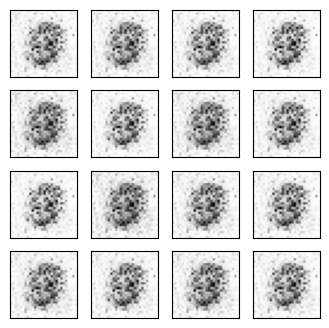

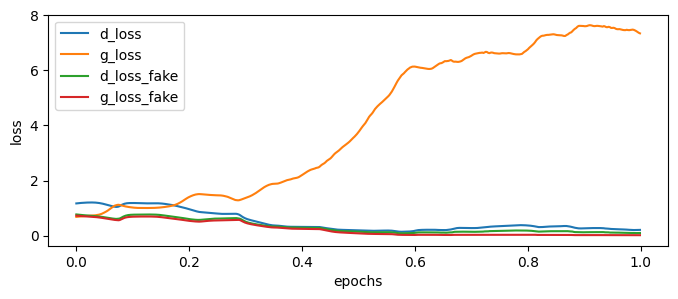

Epoch [2/200], Step[100/469], d_loss: 0.0614, d_loss_fake: 0.0136, g_loss: 6.7095, g_loss_fake: 0.0052, D(x): 0.98, D(G(z)): 0.01
Epoch [2/200], Step[200/469], d_loss: 0.1069, d_loss_fake: 0.0531, g_loss: 4.7896, g_loss_fake: 0.0317, D(x): 0.98, D(G(z)): 0.04
Epoch [2/200], Step[300/469], d_loss: 0.0299, d_loss_fake: 0.0068, g_loss: 5.6563, g_loss_fake: 0.0069, D(x): 0.99, D(G(z)): 0.01
Epoch [2/200], Step[400/469], d_loss: 0.0096, d_loss_fake: 0.0069, g_loss: 5.7229, g_loss_fake: 0.0096, D(x): 1.00, D(G(z)): 0.01
Epoch [3/200], Step[100/469], d_loss: 0.0365, d_loss_fake: 0.0197, g_loss: 5.2364, g_loss_fake: 0.0099, D(x): 0.99, D(G(z)): 0.02
Epoch [3/200], Step[200/469], d_loss: 0.0702, d_loss_fake: 0.0208, g_loss: 6.2837, g_loss_fake: 0.0035, D(x): 0.99, D(G(z)): 0.02
Epoch [3/200], Step[300/469], d_loss: 0.0472, d_loss_fake: 0.0050, g_loss: 5.8698, g_loss_fake: 0.0044, D(x): 0.99, D(G(z)): 0.01
Epoch [3/200], Step[400/469], d_loss: 0.0454, d_loss_fake: 0.0143, g_loss: 5.9980, g_loss_

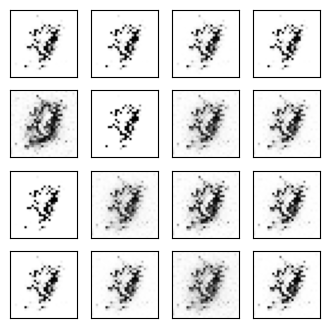

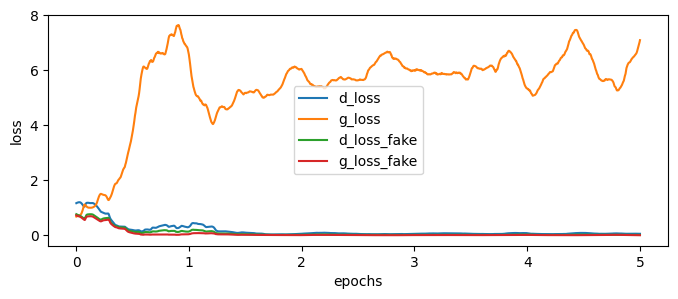

Epoch [6/200], Step[100/469], d_loss: 0.0786, d_loss_fake: 0.0225, g_loss: 3.8588, g_loss_fake: 0.0491, D(x): 0.98, D(G(z)): 0.02
Epoch [6/200], Step[200/469], d_loss: 0.0130, d_loss_fake: 0.0120, g_loss: 5.2385, g_loss_fake: 0.0081, D(x): 1.00, D(G(z)): 0.01
Epoch [6/200], Step[300/469], d_loss: 0.0679, d_loss_fake: 0.0071, g_loss: 6.4034, g_loss_fake: 0.0036, D(x): 0.97, D(G(z)): 0.01
Epoch [6/200], Step[400/469], d_loss: 0.1359, d_loss_fake: 0.1001, g_loss: 5.4037, g_loss_fake: 0.0069, D(x): 0.99, D(G(z)): 0.05
Epoch [7/200], Step[100/469], d_loss: 0.0135, d_loss_fake: 0.0086, g_loss: 5.4459, g_loss_fake: 0.0072, D(x): 1.00, D(G(z)): 0.01
Epoch [7/200], Step[200/469], d_loss: 0.0272, d_loss_fake: 0.0264, g_loss: 5.8686, g_loss_fake: 0.0066, D(x): 1.00, D(G(z)): 0.02
Epoch [7/200], Step[300/469], d_loss: 0.0200, d_loss_fake: 0.0180, g_loss: 6.8694, g_loss_fake: 0.0016, D(x): 1.00, D(G(z)): 0.01
Epoch [7/200], Step[400/469], d_loss: 0.0626, d_loss_fake: 0.0046, g_loss: 7.5558, g_loss_

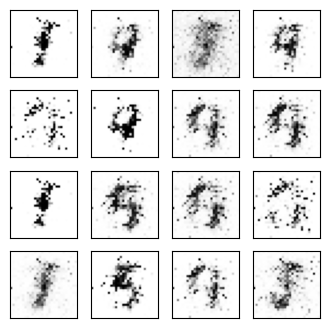

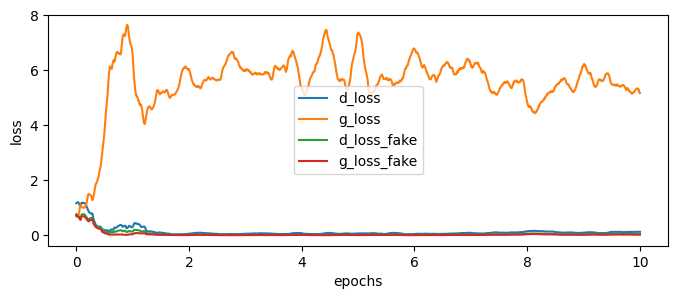

Epoch [11/200], Step[100/469], d_loss: 0.0247, d_loss_fake: 0.0137, g_loss: 5.2743, g_loss_fake: 0.0076, D(x): 0.99, D(G(z)): 0.01
Epoch [11/200], Step[200/469], d_loss: 0.1266, d_loss_fake: 0.0350, g_loss: 5.3972, g_loss_fake: 0.0258, D(x): 0.96, D(G(z)): 0.02
Epoch [11/200], Step[300/469], d_loss: 0.1367, d_loss_fake: 0.0716, g_loss: 5.4178, g_loss_fake: 0.0261, D(x): 0.96, D(G(z)): 0.04
Epoch [11/200], Step[400/469], d_loss: 0.1462, d_loss_fake: 0.0332, g_loss: 5.8264, g_loss_fake: 0.0255, D(x): 0.96, D(G(z)): 0.02
Epoch [12/200], Step[100/469], d_loss: 0.2338, d_loss_fake: 0.1973, g_loss: 4.4730, g_loss_fake: 0.0406, D(x): 0.99, D(G(z)): 0.13
Epoch [12/200], Step[200/469], d_loss: 0.1865, d_loss_fake: 0.1088, g_loss: 3.8157, g_loss_fake: 0.0832, D(x): 0.96, D(G(z)): 0.08
Epoch [12/200], Step[300/469], d_loss: 0.1981, d_loss_fake: 0.0573, g_loss: 5.2932, g_loss_fake: 0.0319, D(x): 0.93, D(G(z)): 0.02
Epoch [12/200], Step[400/469], d_loss: 0.1750, d_loss_fake: 0.0603, g_loss: 4.8159,

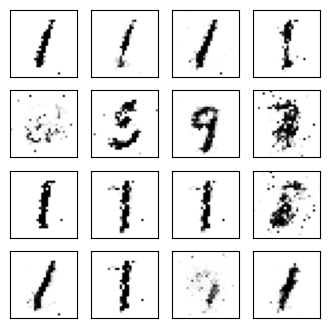

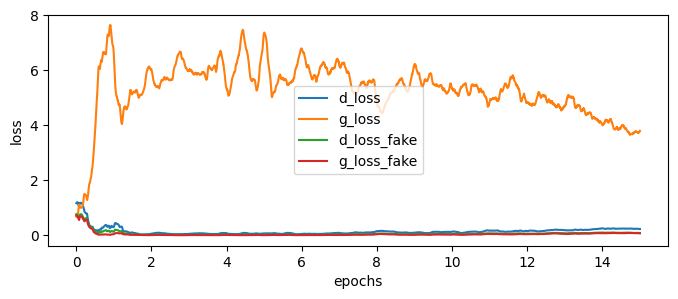

Epoch [16/200], Step[100/469], d_loss: 0.2577, d_loss_fake: 0.0443, g_loss: 3.9748, g_loss_fake: 0.0516, D(x): 0.91, D(G(z)): 0.04
Epoch [16/200], Step[200/469], d_loss: 0.3015, d_loss_fake: 0.1119, g_loss: 3.9968, g_loss_fake: 0.0616, D(x): 0.92, D(G(z)): 0.09
Epoch [16/200], Step[300/469], d_loss: 0.3763, d_loss_fake: 0.1164, g_loss: 4.2018, g_loss_fake: 0.0373, D(x): 0.91, D(G(z)): 0.06
Epoch [16/200], Step[400/469], d_loss: 0.1916, d_loss_fake: 0.1243, g_loss: 4.8889, g_loss_fake: 0.0549, D(x): 0.95, D(G(z)): 0.08
Epoch [17/200], Step[100/469], d_loss: 0.3546, d_loss_fake: 0.2839, g_loss: 3.2097, g_loss_fake: 0.1502, D(x): 0.96, D(G(z)): 0.17
Epoch [17/200], Step[200/469], d_loss: 0.2440, d_loss_fake: 0.1293, g_loss: 2.9885, g_loss_fake: 0.1697, D(x): 0.93, D(G(z)): 0.10
Epoch [17/200], Step[300/469], d_loss: 0.3520, d_loss_fake: 0.1355, g_loss: 2.8715, g_loss_fake: 0.1756, D(x): 0.89, D(G(z)): 0.10
Epoch [17/200], Step[400/469], d_loss: 0.3742, d_loss_fake: 0.2877, g_loss: 3.4866,

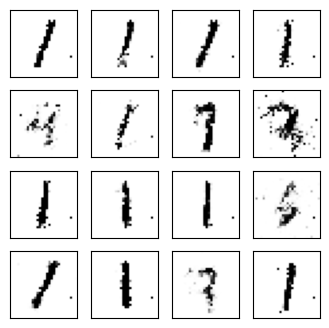

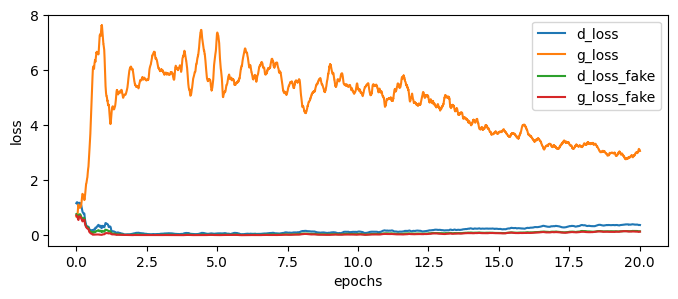

Epoch [21/200], Step[100/469], d_loss: 0.3523, d_loss_fake: 0.1900, g_loss: 2.4000, g_loss_fake: 0.2131, D(x): 0.91, D(G(z)): 0.14
Epoch [21/200], Step[200/469], d_loss: 0.3874, d_loss_fake: 0.1312, g_loss: 3.0949, g_loss_fake: 0.1132, D(x): 0.87, D(G(z)): 0.10
Epoch [21/200], Step[300/469], d_loss: 0.3341, d_loss_fake: 0.1000, g_loss: 3.0352, g_loss_fake: 0.1695, D(x): 0.88, D(G(z)): 0.08
Epoch [21/200], Step[400/469], d_loss: 0.4232, d_loss_fake: 0.1966, g_loss: 2.7586, g_loss_fake: 0.1294, D(x): 0.88, D(G(z)): 0.15
Epoch [22/200], Step[100/469], d_loss: 0.4361, d_loss_fake: 0.1951, g_loss: 2.6446, g_loss_fake: 0.2042, D(x): 0.88, D(G(z)): 0.14
Epoch [22/200], Step[200/469], d_loss: 0.4478, d_loss_fake: 0.1495, g_loss: 2.8188, g_loss_fake: 0.1320, D(x): 0.85, D(G(z)): 0.12
Epoch [22/200], Step[300/469], d_loss: 0.4373, d_loss_fake: 0.1625, g_loss: 2.6860, g_loss_fake: 0.1587, D(x): 0.87, D(G(z)): 0.13
Epoch [22/200], Step[400/469], d_loss: 0.4831, d_loss_fake: 0.1886, g_loss: 2.4707,

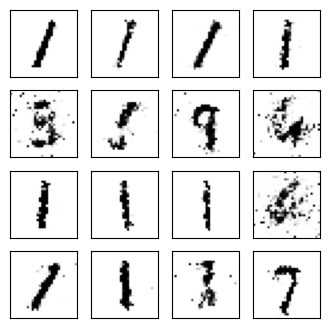

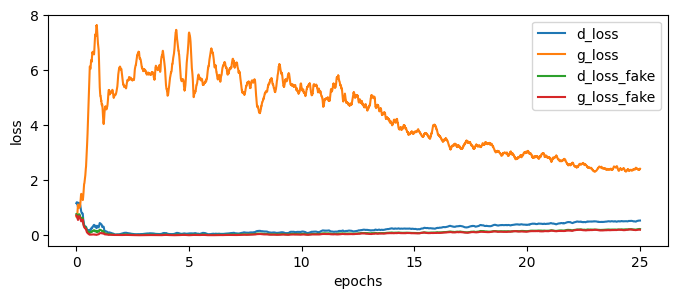

Epoch [26/200], Step[100/469], d_loss: 0.4879, d_loss_fake: 0.2509, g_loss: 2.6017, g_loss_fake: 0.2414, D(x): 0.87, D(G(z)): 0.17
Epoch [26/200], Step[200/469], d_loss: 0.4710, d_loss_fake: 0.2468, g_loss: 2.3947, g_loss_fake: 0.1860, D(x): 0.87, D(G(z)): 0.18
Epoch [26/200], Step[300/469], d_loss: 0.5541, d_loss_fake: 0.2890, g_loss: 2.2216, g_loss_fake: 0.1694, D(x): 0.85, D(G(z)): 0.21
Epoch [26/200], Step[400/469], d_loss: 0.5814, d_loss_fake: 0.3048, g_loss: 1.9812, g_loss_fake: 0.2825, D(x): 0.85, D(G(z)): 0.22
Epoch [27/200], Step[100/469], d_loss: 0.6669, d_loss_fake: 0.1879, g_loss: 2.3372, g_loss_fake: 0.1741, D(x): 0.77, D(G(z)): 0.15
Epoch [27/200], Step[200/469], d_loss: 0.6223, d_loss_fake: 0.1942, g_loss: 2.2700, g_loss_fake: 0.1586, D(x): 0.79, D(G(z)): 0.16
Epoch [27/200], Step[300/469], d_loss: 0.5525, d_loss_fake: 0.2881, g_loss: 2.2229, g_loss_fake: 0.2228, D(x): 0.86, D(G(z)): 0.21
Epoch [27/200], Step[400/469], d_loss: 0.6912, d_loss_fake: 0.3281, g_loss: 1.7777,

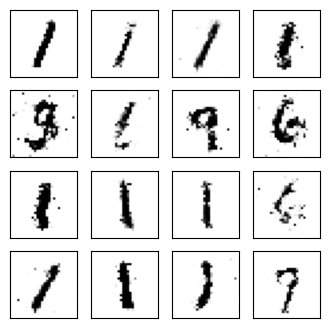

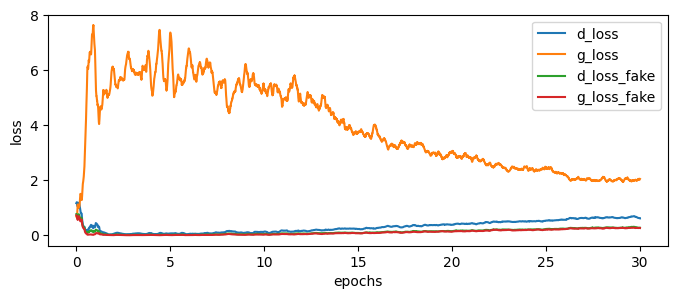

Epoch [31/200], Step[100/469], d_loss: 0.6885, d_loss_fake: 0.3170, g_loss: 1.7245, g_loss_fake: 0.2877, D(x): 0.79, D(G(z)): 0.21
Epoch [31/200], Step[200/469], d_loss: 0.7043, d_loss_fake: 0.2310, g_loss: 1.7378, g_loss_fake: 0.3391, D(x): 0.73, D(G(z)): 0.19
Epoch [31/200], Step[300/469], d_loss: 0.6959, d_loss_fake: 0.3521, g_loss: 1.8000, g_loss_fake: 0.2965, D(x): 0.80, D(G(z)): 0.25
Epoch [31/200], Step[400/469], d_loss: 0.7007, d_loss_fake: 0.3427, g_loss: 1.7829, g_loss_fake: 0.3025, D(x): 0.80, D(G(z)): 0.23
Epoch [32/200], Step[100/469], d_loss: 0.5915, d_loss_fake: 0.2932, g_loss: 1.7958, g_loss_fake: 0.3129, D(x): 0.82, D(G(z)): 0.21
Epoch [32/200], Step[200/469], d_loss: 0.8086, d_loss_fake: 0.3221, g_loss: 1.6601, g_loss_fake: 0.4091, D(x): 0.74, D(G(z)): 0.23
Epoch [32/200], Step[300/469], d_loss: 0.6268, d_loss_fake: 0.3308, g_loss: 1.7792, g_loss_fake: 0.3242, D(x): 0.81, D(G(z)): 0.25
Epoch [32/200], Step[400/469], d_loss: 0.7904, d_loss_fake: 0.3604, g_loss: 2.0079,

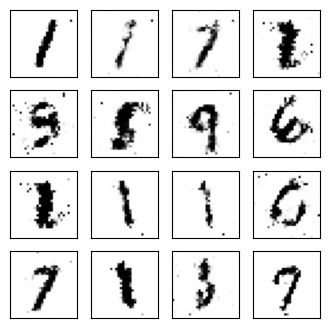

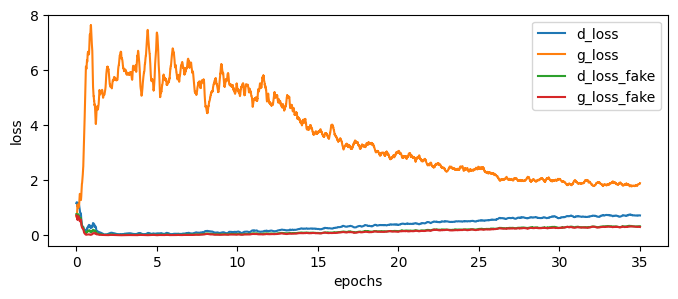

Epoch [36/200], Step[100/469], d_loss: 0.7221, d_loss_fake: 0.3764, g_loss: 1.8469, g_loss_fake: 0.2869, D(x): 0.79, D(G(z)): 0.25
Epoch [36/200], Step[200/469], d_loss: 0.7530, d_loss_fake: 0.2568, g_loss: 1.8784, g_loss_fake: 0.2810, D(x): 0.71, D(G(z)): 0.20
Epoch [36/200], Step[300/469], d_loss: 0.7035, d_loss_fake: 0.2740, g_loss: 1.8786, g_loss_fake: 0.2500, D(x): 0.75, D(G(z)): 0.21
Epoch [36/200], Step[400/469], d_loss: 0.7473, d_loss_fake: 0.3353, g_loss: 1.6573, g_loss_fake: 0.3525, D(x): 0.75, D(G(z)): 0.25
Epoch [37/200], Step[100/469], d_loss: 0.6749, d_loss_fake: 0.3572, g_loss: 1.7119, g_loss_fake: 0.3391, D(x): 0.80, D(G(z)): 0.25
Epoch [37/200], Step[200/469], d_loss: 0.9010, d_loss_fake: 0.2971, g_loss: 1.9670, g_loss_fake: 0.3099, D(x): 0.70, D(G(z)): 0.20
Epoch [37/200], Step[300/469], d_loss: 0.7767, d_loss_fake: 0.3307, g_loss: 1.7185, g_loss_fake: 0.3860, D(x): 0.74, D(G(z)): 0.24
Epoch [37/200], Step[400/469], d_loss: 0.7991, d_loss_fake: 0.3132, g_loss: 1.5816,

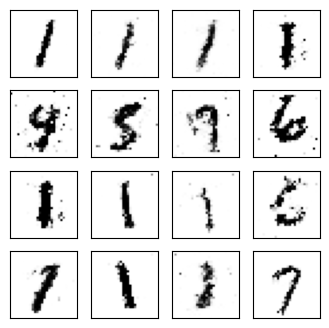

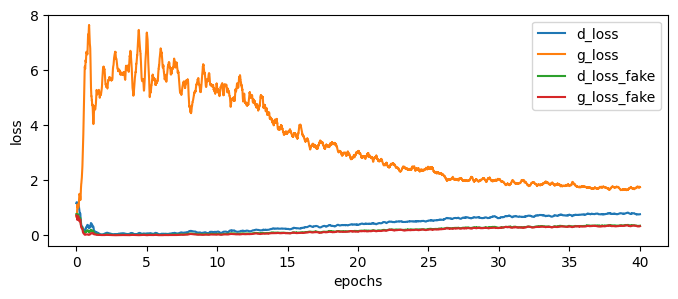

Epoch [41/200], Step[100/469], d_loss: 0.7780, d_loss_fake: 0.3906, g_loss: 1.6708, g_loss_fake: 0.3224, D(x): 0.76, D(G(z)): 0.28
Epoch [41/200], Step[200/469], d_loss: 0.7591, d_loss_fake: 0.3038, g_loss: 1.6586, g_loss_fake: 0.3847, D(x): 0.74, D(G(z)): 0.23
Epoch [41/200], Step[300/469], d_loss: 0.7863, d_loss_fake: 0.2902, g_loss: 1.8157, g_loss_fake: 0.3129, D(x): 0.72, D(G(z)): 0.20
Epoch [41/200], Step[400/469], d_loss: 0.7744, d_loss_fake: 0.3993, g_loss: 1.6969, g_loss_fake: 0.3555, D(x): 0.78, D(G(z)): 0.27
Epoch [42/200], Step[100/469], d_loss: 0.8710, d_loss_fake: 0.4331, g_loss: 1.5640, g_loss_fake: 0.3956, D(x): 0.75, D(G(z)): 0.29
Epoch [42/200], Step[200/469], d_loss: 0.7567, d_loss_fake: 0.3301, g_loss: 1.5835, g_loss_fake: 0.3909, D(x): 0.73, D(G(z)): 0.26
Epoch [42/200], Step[300/469], d_loss: 0.7953, d_loss_fake: 0.3855, g_loss: 1.6417, g_loss_fake: 0.3112, D(x): 0.73, D(G(z)): 0.27
Epoch [42/200], Step[400/469], d_loss: 0.9070, d_loss_fake: 0.4105, g_loss: 1.6577,

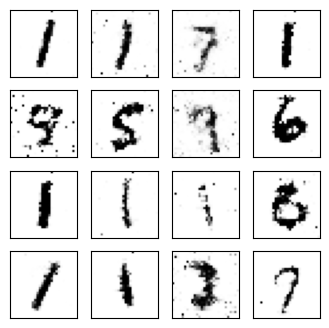

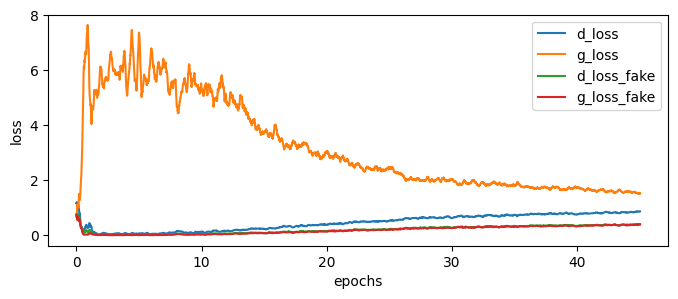

Epoch [46/200], Step[100/469], d_loss: 0.8837, d_loss_fake: 0.2971, g_loss: 1.9750, g_loss_fake: 0.2666, D(x): 0.67, D(G(z)): 0.23
Epoch [46/200], Step[200/469], d_loss: 0.8551, d_loss_fake: 0.3341, g_loss: 1.6843, g_loss_fake: 0.4107, D(x): 0.69, D(G(z)): 0.25
Epoch [46/200], Step[300/469], d_loss: 0.7401, d_loss_fake: 0.3311, g_loss: 1.7475, g_loss_fake: 0.3177, D(x): 0.75, D(G(z)): 0.24
Epoch [46/200], Step[400/469], d_loss: 0.8496, d_loss_fake: 0.4750, g_loss: 1.4032, g_loss_fake: 0.4448, D(x): 0.75, D(G(z)): 0.34
Epoch [47/200], Step[100/469], d_loss: 0.8489, d_loss_fake: 0.3553, g_loss: 1.5313, g_loss_fake: 0.3533, D(x): 0.71, D(G(z)): 0.27
Epoch [47/200], Step[200/469], d_loss: 0.9845, d_loss_fake: 0.5133, g_loss: 1.4243, g_loss_fake: 0.4983, D(x): 0.71, D(G(z)): 0.34
Epoch [47/200], Step[300/469], d_loss: 0.9091, d_loss_fake: 0.4503, g_loss: 1.4486, g_loss_fake: 0.4417, D(x): 0.71, D(G(z)): 0.29
Epoch [47/200], Step[400/469], d_loss: 0.7858, d_loss_fake: 0.4419, g_loss: 1.5308,

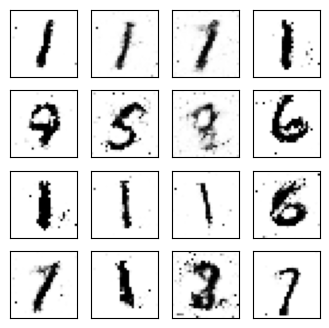

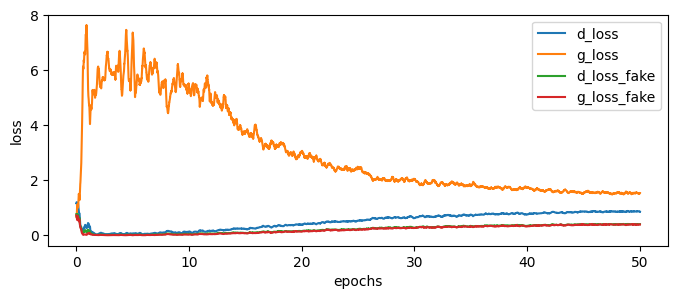

Epoch [51/200], Step[100/469], d_loss: 0.7372, d_loss_fake: 0.4554, g_loss: 1.4989, g_loss_fake: 0.3566, D(x): 0.80, D(G(z)): 0.30
Epoch [51/200], Step[200/469], d_loss: 0.8751, d_loss_fake: 0.4118, g_loss: 1.4109, g_loss_fake: 0.4351, D(x): 0.72, D(G(z)): 0.29
Epoch [51/200], Step[300/469], d_loss: 0.8605, d_loss_fake: 0.3506, g_loss: 1.4835, g_loss_fake: 0.4091, D(x): 0.70, D(G(z)): 0.26
Epoch [51/200], Step[400/469], d_loss: 0.9252, d_loss_fake: 0.4572, g_loss: 1.6166, g_loss_fake: 0.3558, D(x): 0.71, D(G(z)): 0.31
Epoch [52/200], Step[100/469], d_loss: 0.8440, d_loss_fake: 0.3641, g_loss: 1.4812, g_loss_fake: 0.4000, D(x): 0.69, D(G(z)): 0.27
Epoch [52/200], Step[200/469], d_loss: 0.8529, d_loss_fake: 0.4085, g_loss: 1.6567, g_loss_fake: 0.3551, D(x): 0.72, D(G(z)): 0.29
Epoch [52/200], Step[300/469], d_loss: 0.8212, d_loss_fake: 0.4119, g_loss: 1.4971, g_loss_fake: 0.3718, D(x): 0.75, D(G(z)): 0.30
Epoch [52/200], Step[400/469], d_loss: 0.8738, d_loss_fake: 0.4613, g_loss: 1.3259,

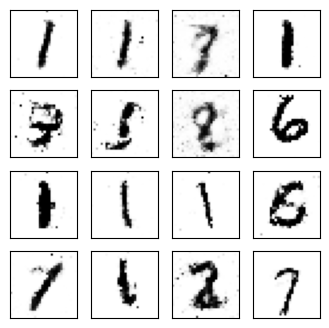

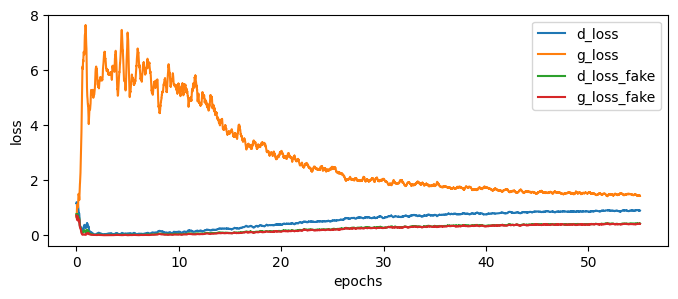

Epoch [56/200], Step[100/469], d_loss: 0.7737, d_loss_fake: 0.3798, g_loss: 1.6484, g_loss_fake: 0.3529, D(x): 0.76, D(G(z)): 0.27
Epoch [56/200], Step[200/469], d_loss: 0.8562, d_loss_fake: 0.4402, g_loss: 1.3514, g_loss_fake: 0.4264, D(x): 0.72, D(G(z)): 0.32
Epoch [56/200], Step[300/469], d_loss: 0.8270, d_loss_fake: 0.4126, g_loss: 1.4593, g_loss_fake: 0.3918, D(x): 0.75, D(G(z)): 0.30
Epoch [56/200], Step[400/469], d_loss: 0.8607, d_loss_fake: 0.4031, g_loss: 1.6453, g_loss_fake: 0.3624, D(x): 0.72, D(G(z)): 0.28
Epoch [57/200], Step[100/469], d_loss: 0.8157, d_loss_fake: 0.4063, g_loss: 1.3901, g_loss_fake: 0.4009, D(x): 0.72, D(G(z)): 0.30
Epoch [57/200], Step[200/469], d_loss: 0.9394, d_loss_fake: 0.4137, g_loss: 1.4375, g_loss_fake: 0.3996, D(x): 0.68, D(G(z)): 0.30
Epoch [57/200], Step[300/469], d_loss: 0.8529, d_loss_fake: 0.4061, g_loss: 1.4757, g_loss_fake: 0.3467, D(x): 0.72, D(G(z)): 0.29
Epoch [57/200], Step[400/469], d_loss: 0.8573, d_loss_fake: 0.3177, g_loss: 1.5533,

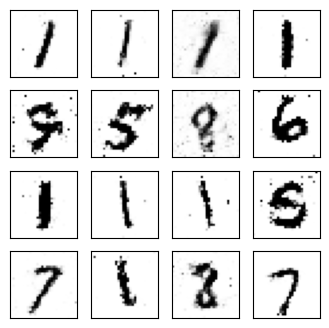

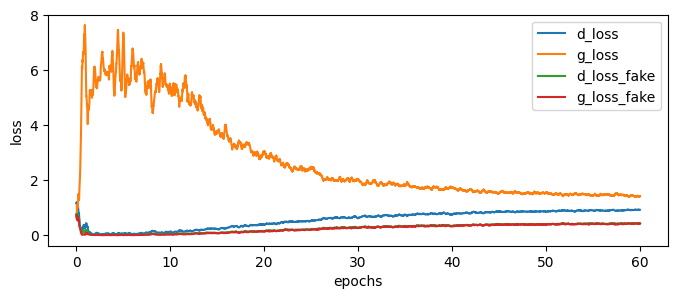

Epoch [61/200], Step[100/469], d_loss: 1.0401, d_loss_fake: 0.5286, g_loss: 1.6367, g_loss_fake: 0.3663, D(x): 0.67, D(G(z)): 0.32
Epoch [61/200], Step[200/469], d_loss: 0.9804, d_loss_fake: 0.4662, g_loss: 1.3238, g_loss_fake: 0.5030, D(x): 0.68, D(G(z)): 0.32
Epoch [61/200], Step[300/469], d_loss: 0.9443, d_loss_fake: 0.4653, g_loss: 1.3388, g_loss_fake: 0.4388, D(x): 0.68, D(G(z)): 0.33
Epoch [61/200], Step[400/469], d_loss: 0.9083, d_loss_fake: 0.4860, g_loss: 1.5095, g_loss_fake: 0.3815, D(x): 0.72, D(G(z)): 0.33
Epoch [62/200], Step[100/469], d_loss: 0.9681, d_loss_fake: 0.4516, g_loss: 1.3535, g_loss_fake: 0.4239, D(x): 0.65, D(G(z)): 0.32
Epoch [62/200], Step[200/469], d_loss: 0.8279, d_loss_fake: 0.4208, g_loss: 1.5848, g_loss_fake: 0.3508, D(x): 0.74, D(G(z)): 0.29
Epoch [62/200], Step[300/469], d_loss: 0.9339, d_loss_fake: 0.5053, g_loss: 1.3224, g_loss_fake: 0.4792, D(x): 0.72, D(G(z)): 0.33
Epoch [62/200], Step[400/469], d_loss: 0.8774, d_loss_fake: 0.3727, g_loss: 1.3552,

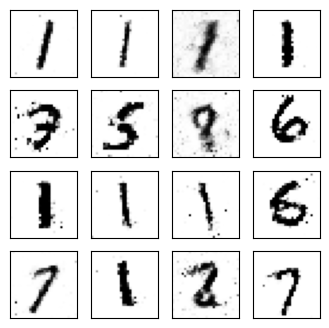

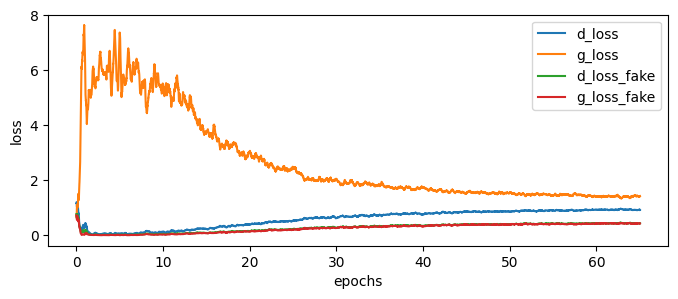

Epoch [66/200], Step[100/469], d_loss: 0.9870, d_loss_fake: 0.4496, g_loss: 1.5538, g_loss_fake: 0.3379, D(x): 0.68, D(G(z)): 0.31
Epoch [66/200], Step[200/469], d_loss: 0.8575, d_loss_fake: 0.3913, g_loss: 1.3727, g_loss_fake: 0.4267, D(x): 0.70, D(G(z)): 0.29
Epoch [66/200], Step[300/469], d_loss: 0.9673, d_loss_fake: 0.4185, g_loss: 1.6377, g_loss_fake: 0.3592, D(x): 0.66, D(G(z)): 0.30
Epoch [66/200], Step[400/469], d_loss: 1.0735, d_loss_fake: 0.4435, g_loss: 1.5459, g_loss_fake: 0.3601, D(x): 0.62, D(G(z)): 0.32
Epoch [67/200], Step[100/469], d_loss: 0.9082, d_loss_fake: 0.4378, g_loss: 1.5389, g_loss_fake: 0.3533, D(x): 0.70, D(G(z)): 0.31
Epoch [67/200], Step[200/469], d_loss: 0.9198, d_loss_fake: 0.4858, g_loss: 1.2703, g_loss_fake: 0.5410, D(x): 0.72, D(G(z)): 0.33
Epoch [67/200], Step[300/469], d_loss: 0.9780, d_loss_fake: 0.3898, g_loss: 1.4392, g_loss_fake: 0.3707, D(x): 0.63, D(G(z)): 0.29
Epoch [67/200], Step[400/469], d_loss: 0.9845, d_loss_fake: 0.4047, g_loss: 1.3985,

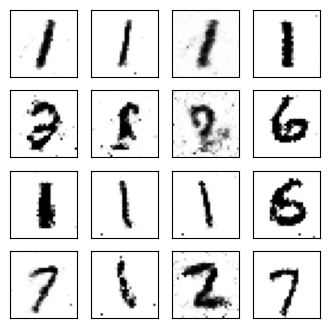

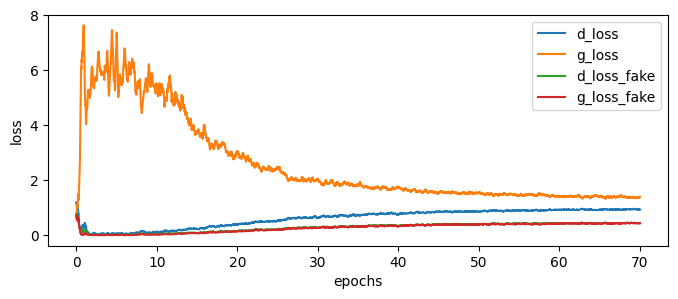

Epoch [71/200], Step[100/469], d_loss: 0.8518, d_loss_fake: 0.4139, g_loss: 1.5864, g_loss_fake: 0.4519, D(x): 0.73, D(G(z)): 0.30
Epoch [71/200], Step[200/469], d_loss: 0.8397, d_loss_fake: 0.4052, g_loss: 1.2537, g_loss_fake: 0.4436, D(x): 0.70, D(G(z)): 0.31
Epoch [71/200], Step[300/469], d_loss: 0.9801, d_loss_fake: 0.4889, g_loss: 1.3427, g_loss_fake: 0.4685, D(x): 0.68, D(G(z)): 0.34
Epoch [71/200], Step[400/469], d_loss: 0.9658, d_loss_fake: 0.4762, g_loss: 1.5124, g_loss_fake: 0.3734, D(x): 0.70, D(G(z)): 0.32
Epoch [72/200], Step[100/469], d_loss: 1.0318, d_loss_fake: 0.4151, g_loss: 1.6535, g_loss_fake: 0.3222, D(x): 0.64, D(G(z)): 0.28
Epoch [72/200], Step[200/469], d_loss: 0.9724, d_loss_fake: 0.4592, g_loss: 1.4433, g_loss_fake: 0.4525, D(x): 0.69, D(G(z)): 0.32
Epoch [72/200], Step[300/469], d_loss: 0.9701, d_loss_fake: 0.5101, g_loss: 1.2986, g_loss_fake: 0.5076, D(x): 0.70, D(G(z)): 0.34
Epoch [72/200], Step[400/469], d_loss: 0.9569, d_loss_fake: 0.4201, g_loss: 1.5028,

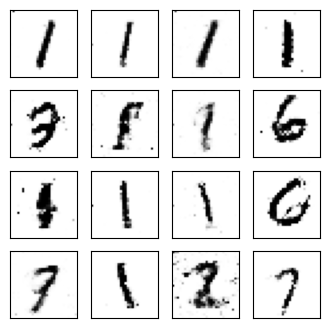

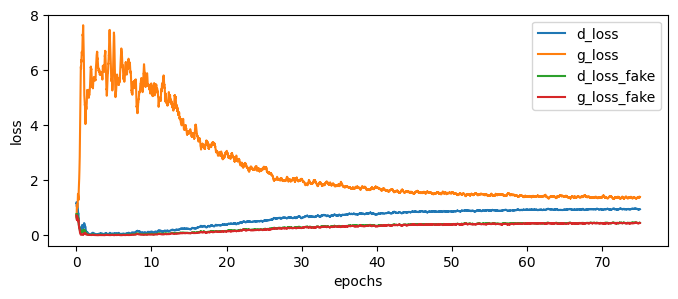

Epoch [76/200], Step[100/469], d_loss: 0.9420, d_loss_fake: 0.4406, g_loss: 1.3824, g_loss_fake: 0.4228, D(x): 0.68, D(G(z)): 0.32
Epoch [76/200], Step[200/469], d_loss: 0.8940, d_loss_fake: 0.3769, g_loss: 1.3981, g_loss_fake: 0.3990, D(x): 0.67, D(G(z)): 0.29
Epoch [76/200], Step[300/469], d_loss: 1.0061, d_loss_fake: 0.4136, g_loss: 1.5201, g_loss_fake: 0.3897, D(x): 0.66, D(G(z)): 0.28
Epoch [76/200], Step[400/469], d_loss: 0.9651, d_loss_fake: 0.3799, g_loss: 1.3426, g_loss_fake: 0.4562, D(x): 0.65, D(G(z)): 0.29
Epoch [77/200], Step[100/469], d_loss: 0.9023, d_loss_fake: 0.3756, g_loss: 1.3818, g_loss_fake: 0.3885, D(x): 0.67, D(G(z)): 0.29
Epoch [77/200], Step[200/469], d_loss: 0.8070, d_loss_fake: 0.4560, g_loss: 1.2147, g_loss_fake: 0.5171, D(x): 0.76, D(G(z)): 0.33
Epoch [77/200], Step[300/469], d_loss: 0.9221, d_loss_fake: 0.4074, g_loss: 1.3692, g_loss_fake: 0.4116, D(x): 0.68, D(G(z)): 0.30
Epoch [77/200], Step[400/469], d_loss: 0.8858, d_loss_fake: 0.4460, g_loss: 1.2786,

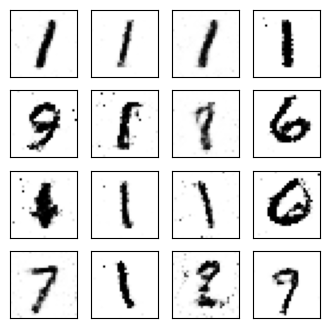

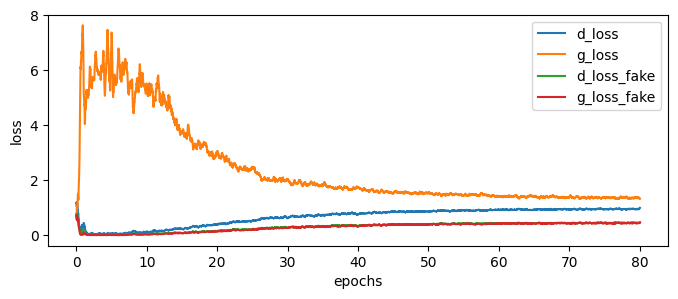

Epoch [81/200], Step[100/469], d_loss: 0.8658, d_loss_fake: 0.4209, g_loss: 1.4253, g_loss_fake: 0.4516, D(x): 0.71, D(G(z)): 0.31
Epoch [81/200], Step[200/469], d_loss: 0.8730, d_loss_fake: 0.4345, g_loss: 1.6091, g_loss_fake: 0.3567, D(x): 0.71, D(G(z)): 0.29
Epoch [81/200], Step[300/469], d_loss: 1.0125, d_loss_fake: 0.5611, g_loss: 1.2084, g_loss_fake: 0.4781, D(x): 0.70, D(G(z)): 0.36
Epoch [81/200], Step[400/469], d_loss: 1.0403, d_loss_fake: 0.4430, g_loss: 1.2721, g_loss_fake: 0.5166, D(x): 0.62, D(G(z)): 0.33
Epoch [82/200], Step[100/469], d_loss: 1.0868, d_loss_fake: 0.5034, g_loss: 1.2771, g_loss_fake: 0.4538, D(x): 0.65, D(G(z)): 0.33
Epoch [82/200], Step[200/469], d_loss: 0.8193, d_loss_fake: 0.3555, g_loss: 1.3193, g_loss_fake: 0.4695, D(x): 0.70, D(G(z)): 0.27
Epoch [82/200], Step[300/469], d_loss: 0.9749, d_loss_fake: 0.4844, g_loss: 1.3099, g_loss_fake: 0.5307, D(x): 0.68, D(G(z)): 0.33
Epoch [82/200], Step[400/469], d_loss: 0.9476, d_loss_fake: 0.5185, g_loss: 1.0734,

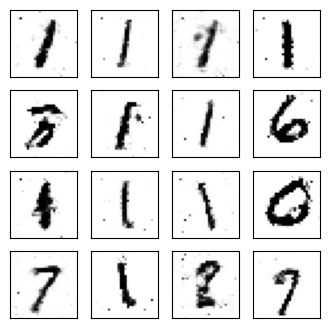

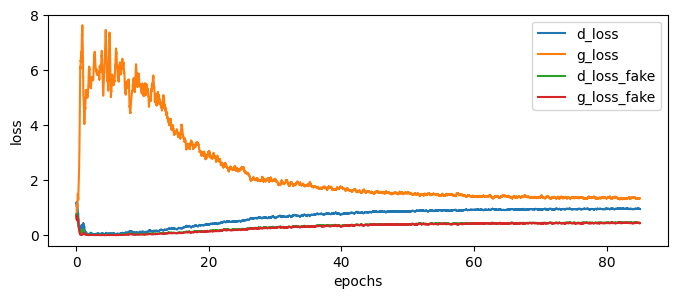

Epoch [86/200], Step[100/469], d_loss: 0.9647, d_loss_fake: 0.4716, g_loss: 1.3155, g_loss_fake: 0.4646, D(x): 0.69, D(G(z)): 0.31
Epoch [86/200], Step[200/469], d_loss: 0.8917, d_loss_fake: 0.4009, g_loss: 1.4084, g_loss_fake: 0.4701, D(x): 0.68, D(G(z)): 0.30
Epoch [86/200], Step[300/469], d_loss: 1.0587, d_loss_fake: 0.5723, g_loss: 1.3894, g_loss_fake: 0.4588, D(x): 0.69, D(G(z)): 0.37
Epoch [86/200], Step[400/469], d_loss: 0.9530, d_loss_fake: 0.4065, g_loss: 1.3207, g_loss_fake: 0.4950, D(x): 0.66, D(G(z)): 0.30
Epoch [87/200], Step[100/469], d_loss: 1.0126, d_loss_fake: 0.4447, g_loss: 1.4578, g_loss_fake: 0.3480, D(x): 0.65, D(G(z)): 0.30
Epoch [87/200], Step[200/469], d_loss: 0.9506, d_loss_fake: 0.4512, g_loss: 1.4415, g_loss_fake: 0.3771, D(x): 0.68, D(G(z)): 0.33
Epoch [87/200], Step[300/469], d_loss: 1.0353, d_loss_fake: 0.5154, g_loss: 1.2020, g_loss_fake: 0.4601, D(x): 0.67, D(G(z)): 0.35
Epoch [87/200], Step[400/469], d_loss: 0.9434, d_loss_fake: 0.4680, g_loss: 1.3022,

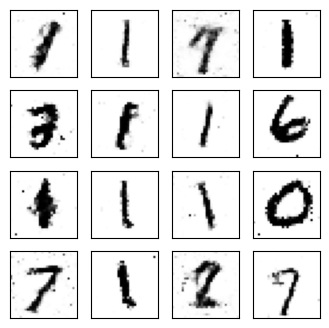

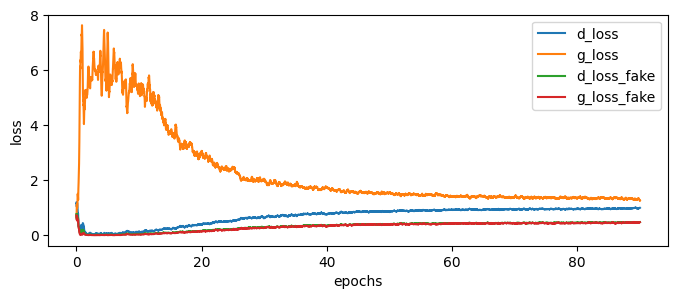

Epoch [91/200], Step[100/469], d_loss: 1.0795, d_loss_fake: 0.4964, g_loss: 1.3808, g_loss_fake: 0.4321, D(x): 0.63, D(G(z)): 0.32
Epoch [91/200], Step[200/469], d_loss: 0.9464, d_loss_fake: 0.4721, g_loss: 1.2985, g_loss_fake: 0.4436, D(x): 0.70, D(G(z)): 0.34
Epoch [91/200], Step[300/469], d_loss: 1.0005, d_loss_fake: 0.5592, g_loss: 1.2234, g_loss_fake: 0.5060, D(x): 0.71, D(G(z)): 0.37
Epoch [91/200], Step[400/469], d_loss: 1.0383, d_loss_fake: 0.4782, g_loss: 1.3243, g_loss_fake: 0.4254, D(x): 0.64, D(G(z)): 0.34
Epoch [92/200], Step[100/469], d_loss: 0.9719, d_loss_fake: 0.4021, g_loss: 1.5320, g_loss_fake: 0.3617, D(x): 0.66, D(G(z)): 0.28
Epoch [92/200], Step[200/469], d_loss: 0.8733, d_loss_fake: 0.4998, g_loss: 1.2729, g_loss_fake: 0.4830, D(x): 0.75, D(G(z)): 0.34
Epoch [92/200], Step[300/469], d_loss: 0.8297, d_loss_fake: 0.3720, g_loss: 1.3926, g_loss_fake: 0.4266, D(x): 0.71, D(G(z)): 0.28
Epoch [92/200], Step[400/469], d_loss: 1.0476, d_loss_fake: 0.5089, g_loss: 1.3755,

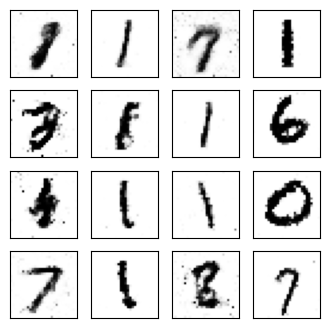

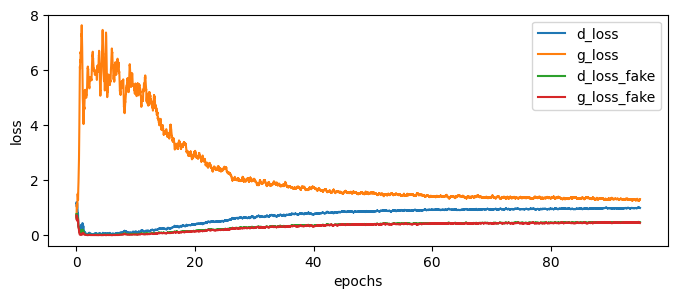

Epoch [96/200], Step[100/469], d_loss: 0.9209, d_loss_fake: 0.3962, g_loss: 1.3111, g_loss_fake: 0.4529, D(x): 0.66, D(G(z)): 0.29
Epoch [96/200], Step[200/469], d_loss: 1.0074, d_loss_fake: 0.4785, g_loss: 1.3900, g_loss_fake: 0.3985, D(x): 0.66, D(G(z)): 0.34
Epoch [96/200], Step[300/469], d_loss: 0.8231, d_loss_fake: 0.3935, g_loss: 1.3378, g_loss_fake: 0.4478, D(x): 0.72, D(G(z)): 0.29
Epoch [96/200], Step[400/469], d_loss: 1.1720, d_loss_fake: 0.4987, g_loss: 1.3571, g_loss_fake: 0.4012, D(x): 0.59, D(G(z)): 0.35
Epoch [97/200], Step[100/469], d_loss: 1.0323, d_loss_fake: 0.5470, g_loss: 1.2002, g_loss_fake: 0.5445, D(x): 0.68, D(G(z)): 0.36
Epoch [97/200], Step[200/469], d_loss: 1.0149, d_loss_fake: 0.4584, g_loss: 1.3565, g_loss_fake: 0.4412, D(x): 0.64, D(G(z)): 0.31
Epoch [97/200], Step[300/469], d_loss: 0.9854, d_loss_fake: 0.4395, g_loss: 1.2462, g_loss_fake: 0.5164, D(x): 0.66, D(G(z)): 0.32
Epoch [97/200], Step[400/469], d_loss: 1.0226, d_loss_fake: 0.4730, g_loss: 1.2758,

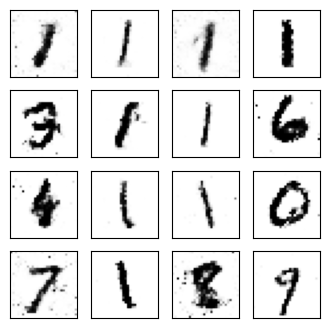

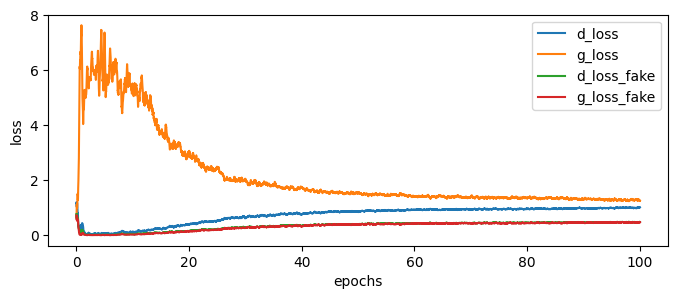

Epoch [101/200], Step[100/469], d_loss: 0.9889, d_loss_fake: 0.4323, g_loss: 1.5233, g_loss_fake: 0.3568, D(x): 0.65, D(G(z)): 0.31
Epoch [101/200], Step[200/469], d_loss: 0.9134, d_loss_fake: 0.4450, g_loss: 1.3576, g_loss_fake: 0.4365, D(x): 0.69, D(G(z)): 0.31
Epoch [101/200], Step[300/469], d_loss: 1.0549, d_loss_fake: 0.4661, g_loss: 1.2800, g_loss_fake: 0.4469, D(x): 0.65, D(G(z)): 0.32
Epoch [101/200], Step[400/469], d_loss: 0.9934, d_loss_fake: 0.5039, g_loss: 1.1618, g_loss_fake: 0.5223, D(x): 0.68, D(G(z)): 0.35
Epoch [102/200], Step[100/469], d_loss: 1.0701, d_loss_fake: 0.4489, g_loss: 1.3003, g_loss_fake: 0.4899, D(x): 0.61, D(G(z)): 0.31
Epoch [102/200], Step[200/469], d_loss: 0.9548, d_loss_fake: 0.4319, g_loss: 1.4154, g_loss_fake: 0.4159, D(x): 0.67, D(G(z)): 0.31
Epoch [102/200], Step[300/469], d_loss: 1.0152, d_loss_fake: 0.5327, g_loss: 1.1575, g_loss_fake: 0.5232, D(x): 0.67, D(G(z)): 0.36
Epoch [102/200], Step[400/469], d_loss: 1.0314, d_loss_fake: 0.4438, g_loss:

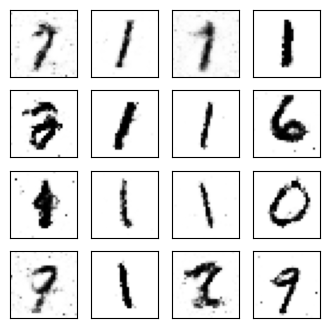

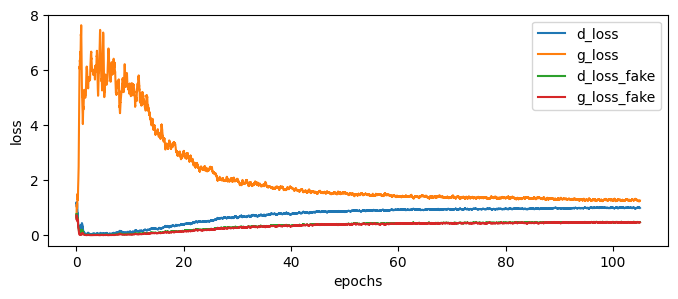

Epoch [106/200], Step[100/469], d_loss: 0.9812, d_loss_fake: 0.4646, g_loss: 1.1591, g_loss_fake: 0.6381, D(x): 0.67, D(G(z)): 0.33
Epoch [106/200], Step[200/469], d_loss: 1.0225, d_loss_fake: 0.5044, g_loss: 1.2186, g_loss_fake: 0.4614, D(x): 0.66, D(G(z)): 0.35
Epoch [106/200], Step[300/469], d_loss: 0.9378, d_loss_fake: 0.4730, g_loss: 1.1675, g_loss_fake: 0.5768, D(x): 0.69, D(G(z)): 0.33
Epoch [106/200], Step[400/469], d_loss: 1.0289, d_loss_fake: 0.5760, g_loss: 1.2397, g_loss_fake: 0.4973, D(x): 0.70, D(G(z)): 0.38
Epoch [107/200], Step[100/469], d_loss: 0.9948, d_loss_fake: 0.5252, g_loss: 1.2352, g_loss_fake: 0.4703, D(x): 0.69, D(G(z)): 0.36
Epoch [107/200], Step[200/469], d_loss: 0.9415, d_loss_fake: 0.4929, g_loss: 1.2900, g_loss_fake: 0.4604, D(x): 0.70, D(G(z)): 0.35
Epoch [107/200], Step[300/469], d_loss: 1.0362, d_loss_fake: 0.4657, g_loss: 1.3209, g_loss_fake: 0.4756, D(x): 0.65, D(G(z)): 0.32
Epoch [107/200], Step[400/469], d_loss: 1.0712, d_loss_fake: 0.4163, g_loss:

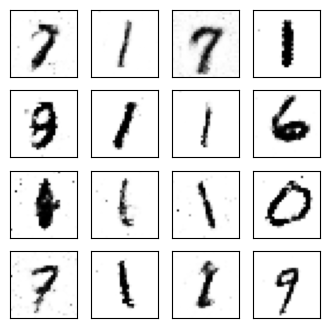

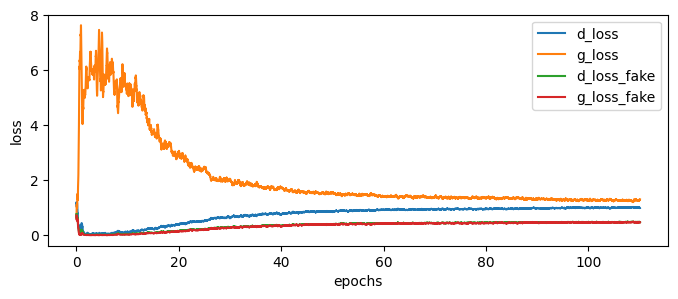

Epoch [111/200], Step[100/469], d_loss: 1.0166, d_loss_fake: 0.4141, g_loss: 1.3647, g_loss_fake: 0.4074, D(x): 0.64, D(G(z)): 0.30
Epoch [111/200], Step[200/469], d_loss: 0.9461, d_loss_fake: 0.4588, g_loss: 1.3580, g_loss_fake: 0.3819, D(x): 0.68, D(G(z)): 0.34
Epoch [111/200], Step[300/469], d_loss: 0.8722, d_loss_fake: 0.4535, g_loss: 1.1561, g_loss_fake: 0.5480, D(x): 0.73, D(G(z)): 0.31
Epoch [111/200], Step[400/469], d_loss: 1.1288, d_loss_fake: 0.5455, g_loss: 1.3451, g_loss_fake: 0.4103, D(x): 0.62, D(G(z)): 0.36
Epoch [112/200], Step[100/469], d_loss: 1.0812, d_loss_fake: 0.5215, g_loss: 1.2192, g_loss_fake: 0.4644, D(x): 0.63, D(G(z)): 0.35
Epoch [112/200], Step[200/469], d_loss: 0.9677, d_loss_fake: 0.4529, g_loss: 1.2453, g_loss_fake: 0.4735, D(x): 0.67, D(G(z)): 0.33
Epoch [112/200], Step[300/469], d_loss: 1.0027, d_loss_fake: 0.5137, g_loss: 1.2594, g_loss_fake: 0.4851, D(x): 0.68, D(G(z)): 0.35
Epoch [112/200], Step[400/469], d_loss: 0.9820, d_loss_fake: 0.4627, g_loss:

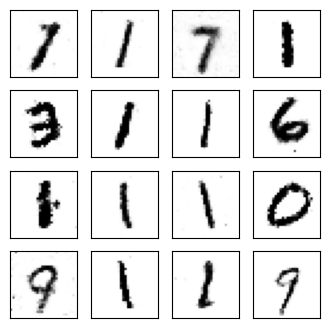

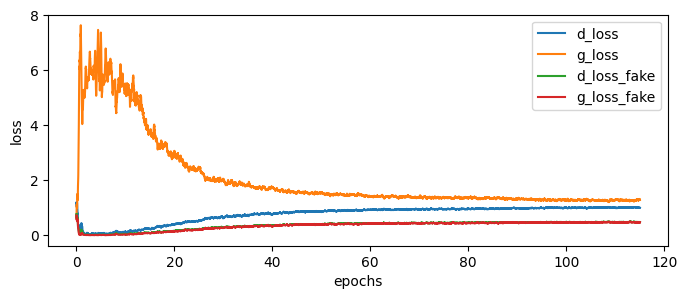

Epoch [116/200], Step[100/469], d_loss: 0.9618, d_loss_fake: 0.4682, g_loss: 1.2056, g_loss_fake: 0.4787, D(x): 0.67, D(G(z)): 0.34
Epoch [116/200], Step[200/469], d_loss: 1.0796, d_loss_fake: 0.4455, g_loss: 1.2507, g_loss_fake: 0.4834, D(x): 0.61, D(G(z)): 0.32
Epoch [116/200], Step[300/469], d_loss: 1.0659, d_loss_fake: 0.6519, g_loss: 1.0440, g_loss_fake: 0.6139, D(x): 0.72, D(G(z)): 0.41
Epoch [116/200], Step[400/469], d_loss: 0.9641, d_loss_fake: 0.4471, g_loss: 1.3915, g_loss_fake: 0.4618, D(x): 0.66, D(G(z)): 0.32
Epoch [117/200], Step[100/469], d_loss: 1.0601, d_loss_fake: 0.5602, g_loss: 1.3149, g_loss_fake: 0.4947, D(x): 0.67, D(G(z)): 0.37
Epoch [117/200], Step[200/469], d_loss: 1.0973, d_loss_fake: 0.5441, g_loss: 1.2309, g_loss_fake: 0.5189, D(x): 0.65, D(G(z)): 0.36
Epoch [117/200], Step[300/469], d_loss: 1.0773, d_loss_fake: 0.5522, g_loss: 1.2475, g_loss_fake: 0.4636, D(x): 0.67, D(G(z)): 0.36
Epoch [117/200], Step[400/469], d_loss: 0.9224, d_loss_fake: 0.4237, g_loss:

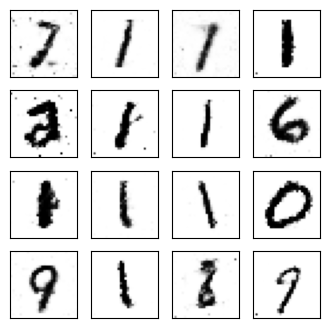

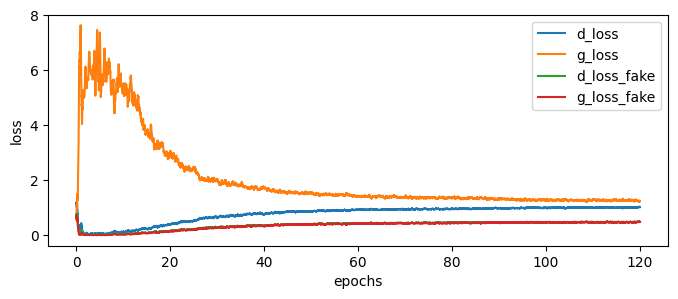

Epoch [121/200], Step[100/469], d_loss: 1.0707, d_loss_fake: 0.4691, g_loss: 1.3993, g_loss_fake: 0.3938, D(x): 0.61, D(G(z)): 0.33
Epoch [121/200], Step[200/469], d_loss: 1.0247, d_loss_fake: 0.4608, g_loss: 1.2290, g_loss_fake: 0.4894, D(x): 0.63, D(G(z)): 0.33
Epoch [121/200], Step[300/469], d_loss: 0.9351, d_loss_fake: 0.3857, g_loss: 1.2923, g_loss_fake: 0.4273, D(x): 0.66, D(G(z)): 0.29
Epoch [121/200], Step[400/469], d_loss: 1.1022, d_loss_fake: 0.5196, g_loss: 1.1781, g_loss_fake: 0.5025, D(x): 0.64, D(G(z)): 0.35
Epoch [122/200], Step[100/469], d_loss: 0.9507, d_loss_fake: 0.4082, g_loss: 1.2364, g_loss_fake: 0.4863, D(x): 0.65, D(G(z)): 0.31
Epoch [122/200], Step[200/469], d_loss: 1.0449, d_loss_fake: 0.5222, g_loss: 1.3094, g_loss_fake: 0.5133, D(x): 0.67, D(G(z)): 0.36
Epoch [122/200], Step[300/469], d_loss: 1.0215, d_loss_fake: 0.4978, g_loss: 1.2207, g_loss_fake: 0.5477, D(x): 0.65, D(G(z)): 0.35
Epoch [122/200], Step[400/469], d_loss: 1.0228, d_loss_fake: 0.4695, g_loss:

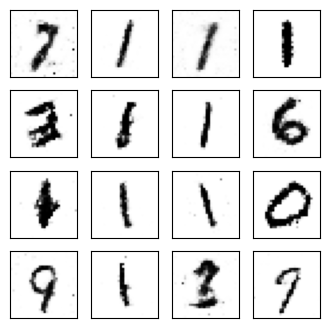

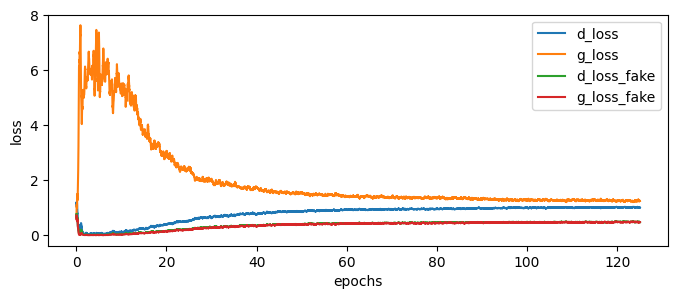

Epoch [126/200], Step[100/469], d_loss: 0.9698, d_loss_fake: 0.4134, g_loss: 1.3094, g_loss_fake: 0.4819, D(x): 0.65, D(G(z)): 0.31
Epoch [126/200], Step[200/469], d_loss: 1.0083, d_loss_fake: 0.4330, g_loss: 1.2870, g_loss_fake: 0.4347, D(x): 0.63, D(G(z)): 0.32
Epoch [126/200], Step[300/469], d_loss: 0.9325, d_loss_fake: 0.4377, g_loss: 1.3377, g_loss_fake: 0.4265, D(x): 0.67, D(G(z)): 0.32
Epoch [126/200], Step[400/469], d_loss: 1.0595, d_loss_fake: 0.4959, g_loss: 1.1685, g_loss_fake: 0.5130, D(x): 0.65, D(G(z)): 0.35
Epoch [127/200], Step[100/469], d_loss: 1.0773, d_loss_fake: 0.5801, g_loss: 1.0758, g_loss_fake: 0.6007, D(x): 0.66, D(G(z)): 0.38
Epoch [127/200], Step[200/469], d_loss: 0.9724, d_loss_fake: 0.4706, g_loss: 1.2050, g_loss_fake: 0.4997, D(x): 0.66, D(G(z)): 0.34
Epoch [127/200], Step[300/469], d_loss: 0.9535, d_loss_fake: 0.4770, g_loss: 1.3107, g_loss_fake: 0.4694, D(x): 0.68, D(G(z)): 0.34
Epoch [127/200], Step[400/469], d_loss: 1.0752, d_loss_fake: 0.5853, g_loss:

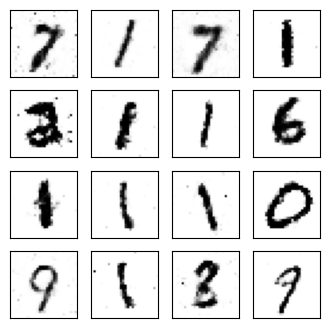

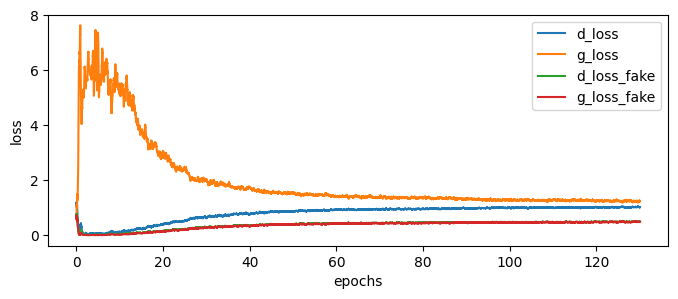

Epoch [131/200], Step[100/469], d_loss: 1.0914, d_loss_fake: 0.5442, g_loss: 1.2024, g_loss_fake: 0.5160, D(x): 0.64, D(G(z)): 0.38
Epoch [131/200], Step[200/469], d_loss: 1.0917, d_loss_fake: 0.5224, g_loss: 1.2652, g_loss_fake: 0.4621, D(x): 0.63, D(G(z)): 0.36
Epoch [131/200], Step[300/469], d_loss: 0.9904, d_loss_fake: 0.5049, g_loss: 1.2828, g_loss_fake: 0.4495, D(x): 0.67, D(G(z)): 0.36
Epoch [131/200], Step[400/469], d_loss: 1.0647, d_loss_fake: 0.4374, g_loss: 1.5631, g_loss_fake: 0.3868, D(x): 0.63, D(G(z)): 0.30
Epoch [132/200], Step[100/469], d_loss: 0.9046, d_loss_fake: 0.4287, g_loss: 1.4109, g_loss_fake: 0.4675, D(x): 0.70, D(G(z)): 0.31
Epoch [132/200], Step[200/469], d_loss: 1.1266, d_loss_fake: 0.4920, g_loss: 1.2685, g_loss_fake: 0.4395, D(x): 0.60, D(G(z)): 0.33
Epoch [132/200], Step[300/469], d_loss: 1.0852, d_loss_fake: 0.5070, g_loss: 1.3202, g_loss_fake: 0.4811, D(x): 0.64, D(G(z)): 0.35
Epoch [132/200], Step[400/469], d_loss: 1.0067, d_loss_fake: 0.3961, g_loss:

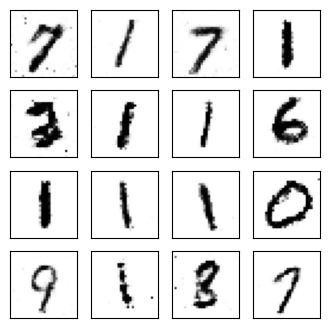

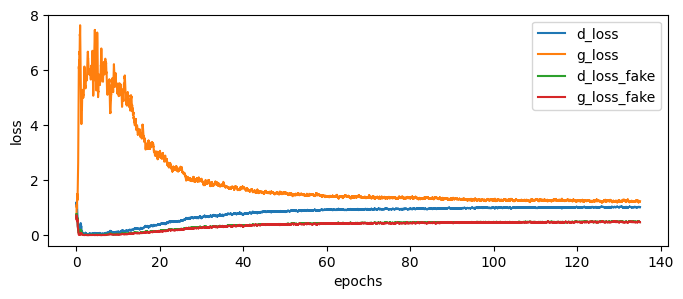

Epoch [136/200], Step[100/469], d_loss: 1.0598, d_loss_fake: 0.4941, g_loss: 1.2440, g_loss_fake: 0.4652, D(x): 0.63, D(G(z)): 0.35
Epoch [136/200], Step[200/469], d_loss: 1.0147, d_loss_fake: 0.4686, g_loss: 1.1726, g_loss_fake: 0.5544, D(x): 0.66, D(G(z)): 0.34
Epoch [136/200], Step[300/469], d_loss: 0.9555, d_loss_fake: 0.4027, g_loss: 1.4336, g_loss_fake: 0.3906, D(x): 0.65, D(G(z)): 0.29
Epoch [136/200], Step[400/469], d_loss: 1.0286, d_loss_fake: 0.4822, g_loss: 1.1586, g_loss_fake: 0.5384, D(x): 0.65, D(G(z)): 0.35
Epoch [137/200], Step[100/469], d_loss: 1.0200, d_loss_fake: 0.5243, g_loss: 1.2213, g_loss_fake: 0.4609, D(x): 0.67, D(G(z)): 0.36
Epoch [137/200], Step[200/469], d_loss: 1.0030, d_loss_fake: 0.5022, g_loss: 1.1742, g_loss_fake: 0.5284, D(x): 0.66, D(G(z)): 0.36
Epoch [137/200], Step[300/469], d_loss: 1.0703, d_loss_fake: 0.5438, g_loss: 1.2931, g_loss_fake: 0.4742, D(x): 0.67, D(G(z)): 0.37
Epoch [137/200], Step[400/469], d_loss: 1.0267, d_loss_fake: 0.4791, g_loss:

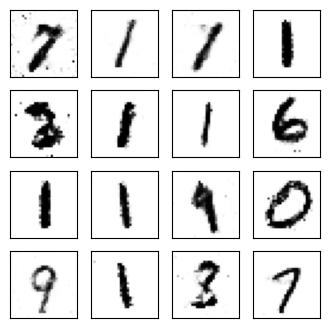

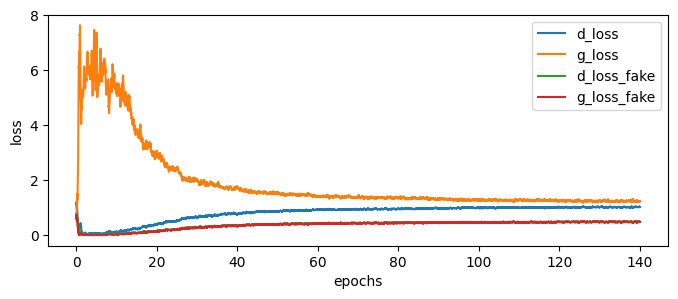

Epoch [141/200], Step[100/469], d_loss: 1.0684, d_loss_fake: 0.5080, g_loss: 1.1993, g_loss_fake: 0.5635, D(x): 0.64, D(G(z)): 0.35
Epoch [141/200], Step[200/469], d_loss: 1.0656, d_loss_fake: 0.4619, g_loss: 1.3974, g_loss_fake: 0.4369, D(x): 0.63, D(G(z)): 0.32
Epoch [141/200], Step[300/469], d_loss: 0.9739, d_loss_fake: 0.4546, g_loss: 1.3320, g_loss_fake: 0.4396, D(x): 0.65, D(G(z)): 0.33
Epoch [141/200], Step[400/469], d_loss: 1.0546, d_loss_fake: 0.5448, g_loss: 1.1130, g_loss_fake: 0.5967, D(x): 0.67, D(G(z)): 0.38
Epoch [142/200], Step[100/469], d_loss: 1.0167, d_loss_fake: 0.4617, g_loss: 1.2684, g_loss_fake: 0.4816, D(x): 0.65, D(G(z)): 0.33
Epoch [142/200], Step[200/469], d_loss: 0.9543, d_loss_fake: 0.5038, g_loss: 1.2593, g_loss_fake: 0.4944, D(x): 0.69, D(G(z)): 0.34
Epoch [142/200], Step[300/469], d_loss: 0.9857, d_loss_fake: 0.5387, g_loss: 1.2864, g_loss_fake: 0.4456, D(x): 0.69, D(G(z)): 0.38
Epoch [142/200], Step[400/469], d_loss: 1.0892, d_loss_fake: 0.5051, g_loss:

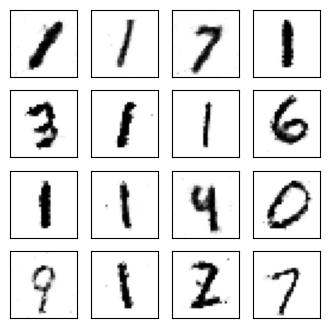

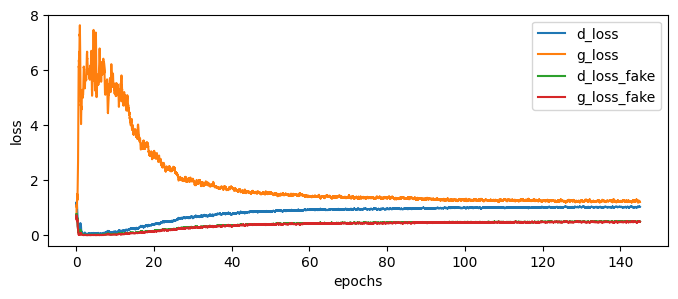

Epoch [146/200], Step[100/469], d_loss: 1.1345, d_loss_fake: 0.6455, g_loss: 1.2338, g_loss_fake: 0.5095, D(x): 0.67, D(G(z)): 0.40
Epoch [146/200], Step[200/469], d_loss: 1.0758, d_loss_fake: 0.5059, g_loss: 1.2432, g_loss_fake: 0.4754, D(x): 0.63, D(G(z)): 0.36
Epoch [146/200], Step[300/469], d_loss: 1.1330, d_loss_fake: 0.6189, g_loss: 1.2034, g_loss_fake: 0.4976, D(x): 0.67, D(G(z)): 0.40
Epoch [146/200], Step[400/469], d_loss: 1.0876, d_loss_fake: 0.5039, g_loss: 1.2484, g_loss_fake: 0.4497, D(x): 0.63, D(G(z)): 0.36
Epoch [147/200], Step[100/469], d_loss: 0.9574, d_loss_fake: 0.4815, g_loss: 1.2540, g_loss_fake: 0.4994, D(x): 0.68, D(G(z)): 0.33
Epoch [147/200], Step[200/469], d_loss: 0.9326, d_loss_fake: 0.4382, g_loss: 1.1944, g_loss_fake: 0.5445, D(x): 0.66, D(G(z)): 0.32
Epoch [147/200], Step[300/469], d_loss: 1.0409, d_loss_fake: 0.5146, g_loss: 1.1334, g_loss_fake: 0.5233, D(x): 0.66, D(G(z)): 0.36
Epoch [147/200], Step[400/469], d_loss: 1.0776, d_loss_fake: 0.4622, g_loss:

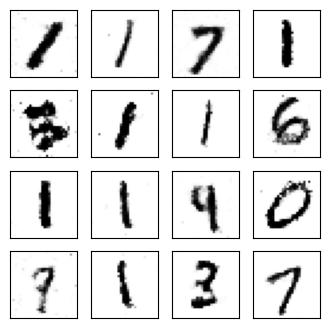

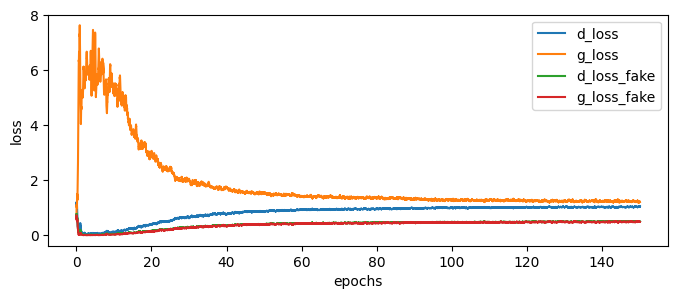

Epoch [151/200], Step[100/469], d_loss: 0.9835, d_loss_fake: 0.4490, g_loss: 1.3333, g_loss_fake: 0.4914, D(x): 0.66, D(G(z)): 0.33
Epoch [151/200], Step[200/469], d_loss: 1.0059, d_loss_fake: 0.5133, g_loss: 1.1759, g_loss_fake: 0.5208, D(x): 0.68, D(G(z)): 0.36
Epoch [151/200], Step[300/469], d_loss: 1.0052, d_loss_fake: 0.4839, g_loss: 1.2042, g_loss_fake: 0.5091, D(x): 0.65, D(G(z)): 0.34
Epoch [151/200], Step[400/469], d_loss: 1.0016, d_loss_fake: 0.4601, g_loss: 1.2640, g_loss_fake: 0.4451, D(x): 0.65, D(G(z)): 0.33
Epoch [152/200], Step[100/469], d_loss: 0.9515, d_loss_fake: 0.3817, g_loss: 1.3918, g_loss_fake: 0.4622, D(x): 0.65, D(G(z)): 0.29
Epoch [152/200], Step[200/469], d_loss: 1.0568, d_loss_fake: 0.4867, g_loss: 1.2363, g_loss_fake: 0.4914, D(x): 0.64, D(G(z)): 0.34
Epoch [152/200], Step[300/469], d_loss: 1.0273, d_loss_fake: 0.5042, g_loss: 1.2867, g_loss_fake: 0.4596, D(x): 0.66, D(G(z)): 0.36
Epoch [152/200], Step[400/469], d_loss: 1.0548, d_loss_fake: 0.4872, g_loss:

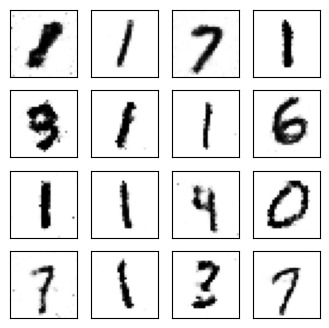

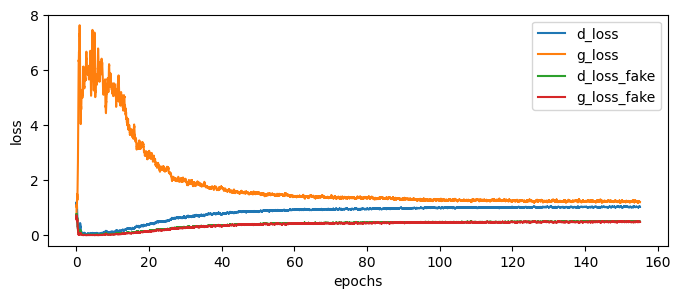

Epoch [156/200], Step[100/469], d_loss: 0.9897, d_loss_fake: 0.4608, g_loss: 1.3851, g_loss_fake: 0.4156, D(x): 0.66, D(G(z)): 0.32
Epoch [156/200], Step[200/469], d_loss: 0.9456, d_loss_fake: 0.3629, g_loss: 1.3221, g_loss_fake: 0.4798, D(x): 0.64, D(G(z)): 0.28
Epoch [156/200], Step[300/469], d_loss: 0.8955, d_loss_fake: 0.4716, g_loss: 1.2229, g_loss_fake: 0.5079, D(x): 0.71, D(G(z)): 0.34
Epoch [156/200], Step[400/469], d_loss: 0.9860, d_loss_fake: 0.4753, g_loss: 1.3510, g_loss_fake: 0.4319, D(x): 0.67, D(G(z)): 0.34
Epoch [157/200], Step[100/469], d_loss: 0.9687, d_loss_fake: 0.4382, g_loss: 1.2909, g_loss_fake: 0.4766, D(x): 0.65, D(G(z)): 0.32
Epoch [157/200], Step[200/469], d_loss: 1.0338, d_loss_fake: 0.5247, g_loss: 1.1962, g_loss_fake: 0.4881, D(x): 0.66, D(G(z)): 0.37
Epoch [157/200], Step[300/469], d_loss: 0.9665, d_loss_fake: 0.4892, g_loss: 1.1737, g_loss_fake: 0.5817, D(x): 0.68, D(G(z)): 0.35
Epoch [157/200], Step[400/469], d_loss: 1.0039, d_loss_fake: 0.4626, g_loss:

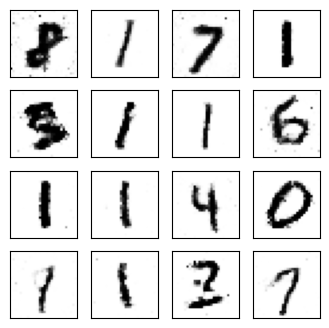

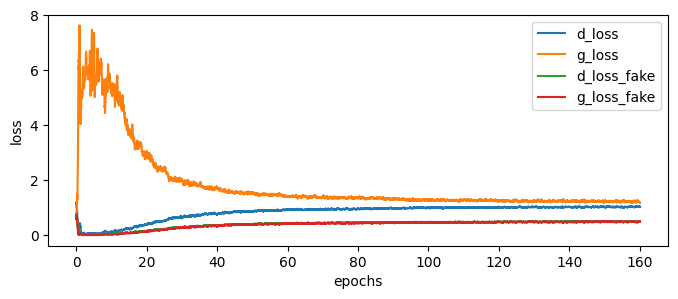

Epoch [161/200], Step[100/469], d_loss: 0.9620, d_loss_fake: 0.4690, g_loss: 1.1783, g_loss_fake: 0.5259, D(x): 0.67, D(G(z)): 0.34
Epoch [161/200], Step[200/469], d_loss: 1.0130, d_loss_fake: 0.3804, g_loss: 1.4579, g_loss_fake: 0.3802, D(x): 0.60, D(G(z)): 0.29
Epoch [161/200], Step[300/469], d_loss: 1.0399, d_loss_fake: 0.5153, g_loss: 1.2969, g_loss_fake: 0.4217, D(x): 0.66, D(G(z)): 0.37
Epoch [161/200], Step[400/469], d_loss: 1.1203, d_loss_fake: 0.6121, g_loss: 1.2805, g_loss_fake: 0.4800, D(x): 0.66, D(G(z)): 0.39
Epoch [162/200], Step[100/469], d_loss: 0.9715, d_loss_fake: 0.4017, g_loss: 1.4641, g_loss_fake: 0.4036, D(x): 0.64, D(G(z)): 0.30
Epoch [162/200], Step[200/469], d_loss: 1.0184, d_loss_fake: 0.4338, g_loss: 1.4120, g_loss_fake: 0.3666, D(x): 0.62, D(G(z)): 0.32
Epoch [162/200], Step[300/469], d_loss: 0.9814, d_loss_fake: 0.4980, g_loss: 1.1985, g_loss_fake: 0.5288, D(x): 0.68, D(G(z)): 0.36
Epoch [162/200], Step[400/469], d_loss: 0.9074, d_loss_fake: 0.4448, g_loss:

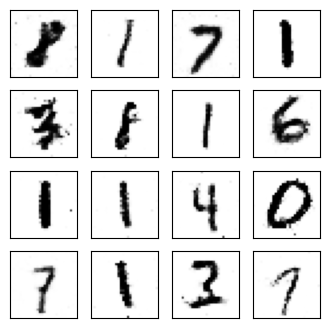

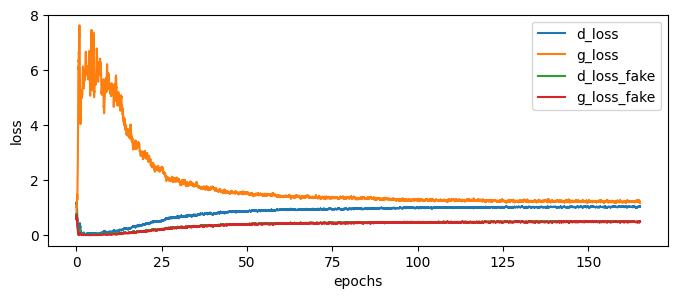

Epoch [166/200], Step[100/469], d_loss: 0.9689, d_loss_fake: 0.4334, g_loss: 1.4187, g_loss_fake: 0.3591, D(x): 0.65, D(G(z)): 0.32
Epoch [166/200], Step[200/469], d_loss: 1.0477, d_loss_fake: 0.4454, g_loss: 1.3181, g_loss_fake: 0.4328, D(x): 0.61, D(G(z)): 0.32
Epoch [166/200], Step[300/469], d_loss: 1.0516, d_loss_fake: 0.5364, g_loss: 1.1688, g_loss_fake: 0.4962, D(x): 0.66, D(G(z)): 0.38
Epoch [166/200], Step[400/469], d_loss: 0.9322, d_loss_fake: 0.4688, g_loss: 1.2553, g_loss_fake: 0.4333, D(x): 0.68, D(G(z)): 0.33
Epoch [167/200], Step[100/469], d_loss: 0.9578, d_loss_fake: 0.4193, g_loss: 1.2730, g_loss_fake: 0.4497, D(x): 0.64, D(G(z)): 0.31
Epoch [167/200], Step[200/469], d_loss: 1.0304, d_loss_fake: 0.4579, g_loss: 1.1775, g_loss_fake: 0.5232, D(x): 0.64, D(G(z)): 0.33
Epoch [167/200], Step[300/469], d_loss: 0.9804, d_loss_fake: 0.4468, g_loss: 1.2719, g_loss_fake: 0.4561, D(x): 0.65, D(G(z)): 0.32
Epoch [167/200], Step[400/469], d_loss: 1.0206, d_loss_fake: 0.5036, g_loss:

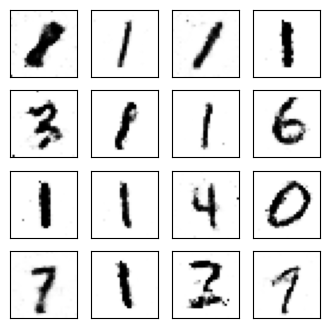

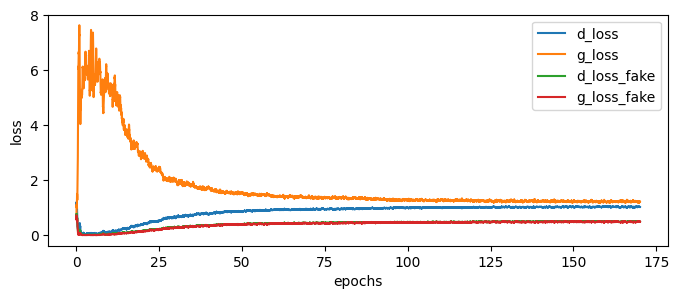

Epoch [171/200], Step[100/469], d_loss: 1.0655, d_loss_fake: 0.4231, g_loss: 1.2851, g_loss_fake: 0.4567, D(x): 0.60, D(G(z)): 0.31
Epoch [171/200], Step[200/469], d_loss: 1.0555, d_loss_fake: 0.5123, g_loss: 1.2037, g_loss_fake: 0.4914, D(x): 0.65, D(G(z)): 0.35
Epoch [171/200], Step[300/469], d_loss: 0.9460, d_loss_fake: 0.4790, g_loss: 1.2901, g_loss_fake: 0.5415, D(x): 0.68, D(G(z)): 0.32
Epoch [171/200], Step[400/469], d_loss: 1.1245, d_loss_fake: 0.5413, g_loss: 1.2101, g_loss_fake: 0.4644, D(x): 0.62, D(G(z)): 0.38
Epoch [172/200], Step[100/469], d_loss: 0.8692, d_loss_fake: 0.3735, g_loss: 1.4213, g_loss_fake: 0.4170, D(x): 0.68, D(G(z)): 0.28
Epoch [172/200], Step[200/469], d_loss: 0.8622, d_loss_fake: 0.4107, g_loss: 1.2686, g_loss_fake: 0.4881, D(x): 0.69, D(G(z)): 0.32
Epoch [172/200], Step[300/469], d_loss: 1.0514, d_loss_fake: 0.5221, g_loss: 1.1264, g_loss_fake: 0.5451, D(x): 0.66, D(G(z)): 0.37
Epoch [172/200], Step[400/469], d_loss: 0.9948, d_loss_fake: 0.4977, g_loss:

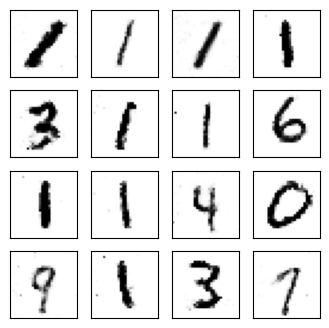

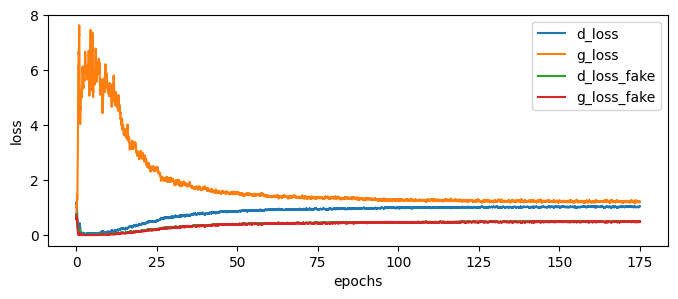

Epoch [176/200], Step[100/469], d_loss: 1.0677, d_loss_fake: 0.5023, g_loss: 1.2898, g_loss_fake: 0.4271, D(x): 0.63, D(G(z)): 0.36
Epoch [176/200], Step[200/469], d_loss: 1.1319, d_loss_fake: 0.5983, g_loss: 1.2080, g_loss_fake: 0.4846, D(x): 0.66, D(G(z)): 0.39
Epoch [176/200], Step[300/469], d_loss: 1.0629, d_loss_fake: 0.4621, g_loss: 1.3056, g_loss_fake: 0.4305, D(x): 0.63, D(G(z)): 0.33
Epoch [176/200], Step[400/469], d_loss: 1.1226, d_loss_fake: 0.5594, g_loss: 1.2574, g_loss_fake: 0.4475, D(x): 0.63, D(G(z)): 0.39
Epoch [177/200], Step[100/469], d_loss: 1.1210, d_loss_fake: 0.5043, g_loss: 1.3194, g_loss_fake: 0.3975, D(x): 0.60, D(G(z)): 0.35
Epoch [177/200], Step[200/469], d_loss: 1.0842, d_loss_fake: 0.5491, g_loss: 1.3632, g_loss_fake: 0.4204, D(x): 0.66, D(G(z)): 0.37
Epoch [177/200], Step[300/469], d_loss: 1.0740, d_loss_fake: 0.5079, g_loss: 1.1792, g_loss_fake: 0.4776, D(x): 0.64, D(G(z)): 0.37
Epoch [177/200], Step[400/469], d_loss: 1.0451, d_loss_fake: 0.5279, g_loss:

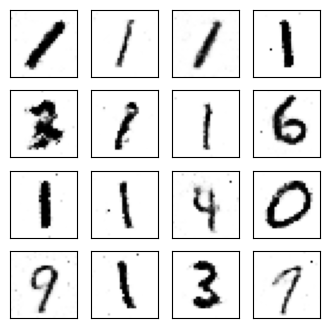

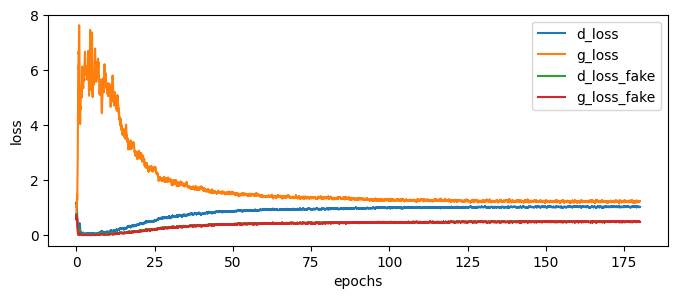

Epoch [181/200], Step[100/469], d_loss: 1.0314, d_loss_fake: 0.5201, g_loss: 1.1497, g_loss_fake: 0.5272, D(x): 0.67, D(G(z)): 0.35
Epoch [181/200], Step[200/469], d_loss: 1.2415, d_loss_fake: 0.5983, g_loss: 1.2167, g_loss_fake: 0.4829, D(x): 0.59, D(G(z)): 0.39
Epoch [181/200], Step[300/469], d_loss: 0.9767, d_loss_fake: 0.5292, g_loss: 1.2649, g_loss_fake: 0.4903, D(x): 0.69, D(G(z)): 0.36
Epoch [181/200], Step[400/469], d_loss: 1.0998, d_loss_fake: 0.4349, g_loss: 1.2976, g_loss_fake: 0.4517, D(x): 0.59, D(G(z)): 0.32
Epoch [182/200], Step[100/469], d_loss: 1.1489, d_loss_fake: 0.5367, g_loss: 1.0490, g_loss_fake: 0.5439, D(x): 0.61, D(G(z)): 0.38
Epoch [182/200], Step[200/469], d_loss: 0.9976, d_loss_fake: 0.5112, g_loss: 1.2926, g_loss_fake: 0.4582, D(x): 0.67, D(G(z)): 0.35
Epoch [182/200], Step[300/469], d_loss: 0.9634, d_loss_fake: 0.5042, g_loss: 1.1417, g_loss_fake: 0.5637, D(x): 0.71, D(G(z)): 0.34
Epoch [182/200], Step[400/469], d_loss: 0.9374, d_loss_fake: 0.4940, g_loss:

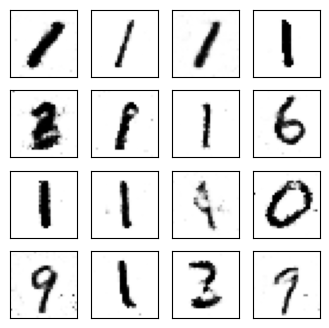

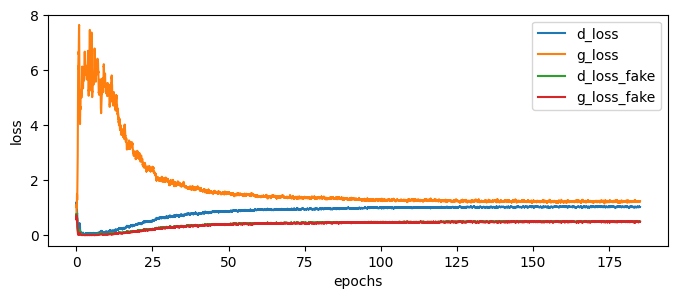

Epoch [186/200], Step[100/469], d_loss: 1.0802, d_loss_fake: 0.5074, g_loss: 1.1782, g_loss_fake: 0.5434, D(x): 0.64, D(G(z)): 0.35
Epoch [186/200], Step[200/469], d_loss: 0.9679, d_loss_fake: 0.4307, g_loss: 1.2313, g_loss_fake: 0.4914, D(x): 0.65, D(G(z)): 0.32
Epoch [186/200], Step[300/469], d_loss: 1.0696, d_loss_fake: 0.4456, g_loss: 1.2016, g_loss_fake: 0.4708, D(x): 0.61, D(G(z)): 0.31
Epoch [186/200], Step[400/469], d_loss: 0.9814, d_loss_fake: 0.5245, g_loss: 1.0786, g_loss_fake: 0.5772, D(x): 0.69, D(G(z)): 0.36
Epoch [187/200], Step[100/469], d_loss: 0.9380, d_loss_fake: 0.3666, g_loss: 1.2374, g_loss_fake: 0.4945, D(x): 0.63, D(G(z)): 0.28
Epoch [187/200], Step[200/469], d_loss: 1.2079, d_loss_fake: 0.5627, g_loss: 1.2530, g_loss_fake: 0.4500, D(x): 0.59, D(G(z)): 0.36
Epoch [187/200], Step[300/469], d_loss: 1.1073, d_loss_fake: 0.6386, g_loss: 1.2431, g_loss_fake: 0.5243, D(x): 0.69, D(G(z)): 0.39
Epoch [187/200], Step[400/469], d_loss: 1.0234, d_loss_fake: 0.4361, g_loss:

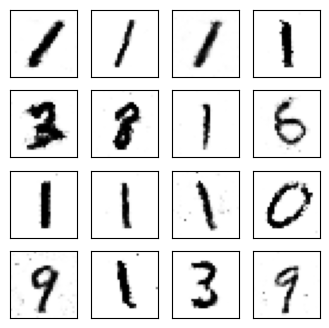

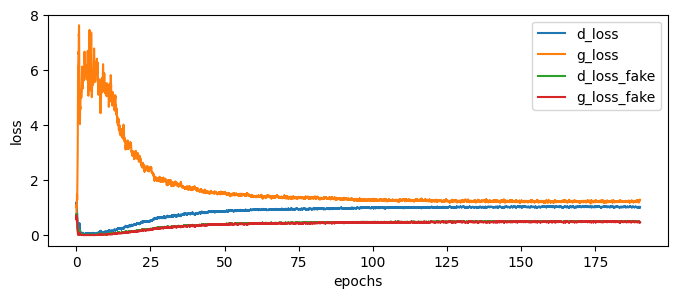

Epoch [191/200], Step[100/469], d_loss: 1.0319, d_loss_fake: 0.6157, g_loss: 1.2551, g_loss_fake: 0.5010, D(x): 0.72, D(G(z)): 0.40
Epoch [191/200], Step[200/469], d_loss: 1.1031, d_loss_fake: 0.4482, g_loss: 1.3651, g_loss_fake: 0.4243, D(x): 0.60, D(G(z)): 0.34
Epoch [191/200], Step[300/469], d_loss: 1.0159, d_loss_fake: 0.4601, g_loss: 1.1787, g_loss_fake: 0.5256, D(x): 0.64, D(G(z)): 0.33
Epoch [191/200], Step[400/469], d_loss: 1.0722, d_loss_fake: 0.4867, g_loss: 1.3055, g_loss_fake: 0.4510, D(x): 0.62, D(G(z)): 0.34
Epoch [192/200], Step[100/469], d_loss: 1.0350, d_loss_fake: 0.4423, g_loss: 1.2501, g_loss_fake: 0.4422, D(x): 0.62, D(G(z)): 0.33
Epoch [192/200], Step[200/469], d_loss: 1.0726, d_loss_fake: 0.5611, g_loss: 1.0940, g_loss_fake: 0.5893, D(x): 0.66, D(G(z)): 0.39
Epoch [192/200], Step[300/469], d_loss: 0.9878, d_loss_fake: 0.4232, g_loss: 1.2735, g_loss_fake: 0.4516, D(x): 0.64, D(G(z)): 0.32
Epoch [192/200], Step[400/469], d_loss: 0.9703, d_loss_fake: 0.4797, g_loss:

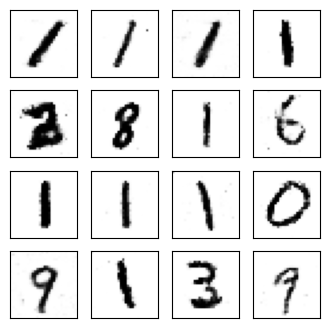

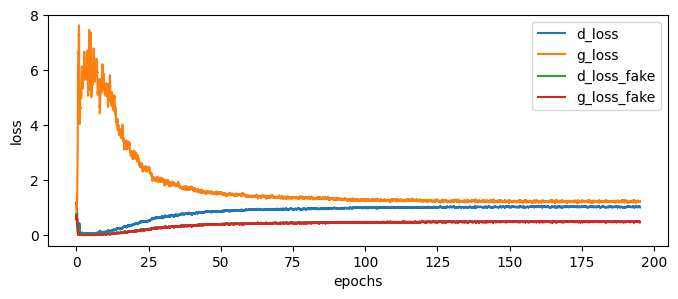

Epoch [196/200], Step[100/469], d_loss: 0.9726, d_loss_fake: 0.4379, g_loss: 1.3297, g_loss_fake: 0.4403, D(x): 0.65, D(G(z)): 0.31
Epoch [196/200], Step[200/469], d_loss: 1.0912, d_loss_fake: 0.5344, g_loss: 1.2734, g_loss_fake: 0.5070, D(x): 0.64, D(G(z)): 0.36
Epoch [196/200], Step[300/469], d_loss: 1.0211, d_loss_fake: 0.4115, g_loss: 1.1934, g_loss_fake: 0.5217, D(x): 0.62, D(G(z)): 0.31
Epoch [196/200], Step[400/469], d_loss: 0.9333, d_loss_fake: 0.4414, g_loss: 1.0895, g_loss_fake: 0.6082, D(x): 0.68, D(G(z)): 0.33
Epoch [197/200], Step[100/469], d_loss: 0.9070, d_loss_fake: 0.4567, g_loss: 1.2045, g_loss_fake: 0.5070, D(x): 0.69, D(G(z)): 0.33
Epoch [197/200], Step[200/469], d_loss: 0.9392, d_loss_fake: 0.4593, g_loss: 1.1721, g_loss_fake: 0.4842, D(x): 0.68, D(G(z)): 0.34
Epoch [197/200], Step[300/469], d_loss: 0.9256, d_loss_fake: 0.4665, g_loss: 1.3860, g_loss_fake: 0.3914, D(x): 0.69, D(G(z)): 0.34
Epoch [197/200], Step[400/469], d_loss: 1.0660, d_loss_fake: 0.6006, g_loss:

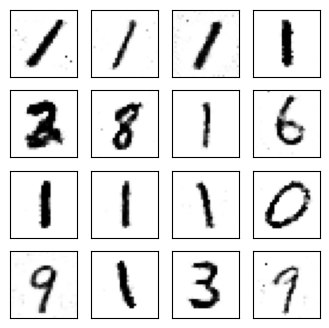

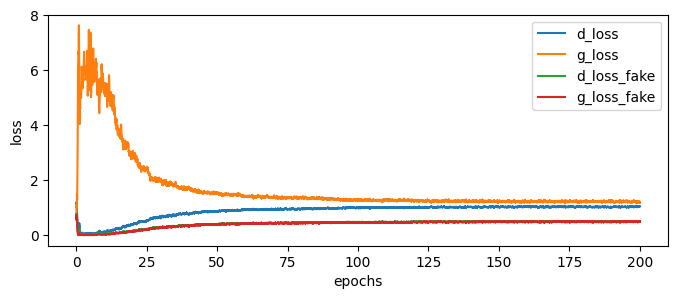

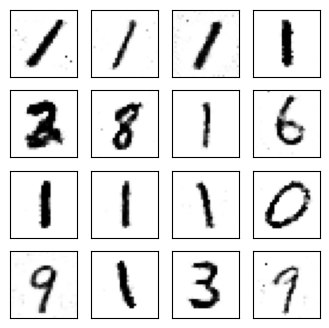

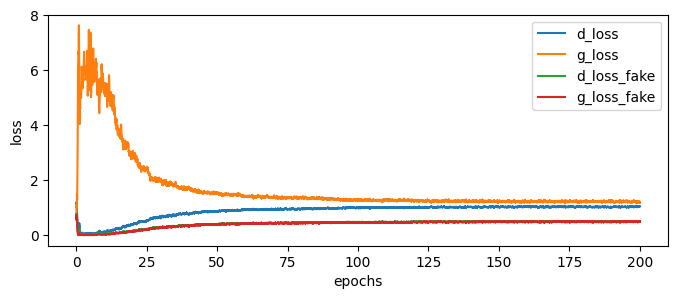

In [10]:
##################
### Problem 2: Ablation study 1, 2, and 3
##################
# set number of epochs and initialize figure counter

# Ablation 2:  Increase the capacity of the discriminator by increasing the number of layers

dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = False

discriminator = Discriminator(channels=[512, (512 + 256) // 2, 256, (256 + 128) // 2, 128], with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

num_epochs = 200
d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

# **2. Conditional GAN**

In [ ]:
num_epochs = 500
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = True

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)